# Imports

In [55]:
%reset -f
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering

from sklearn.cluster import DBSCAN, dbscan

from controller import Controller

In [57]:
c = Controller('i03')

TEXT_FEATURES = ['NAME', 'DESC', 'KEYWORDS']
DATE_FEATURES = ['DEADLINE', 'STATE_CHANGED_AT', 'CREATED_AT', 'LAUNCHED_AT']
NOMINAL_FEATURES = ['DISABLE_COMMUNICATION', 'COUNTRY', 'CURRENCY']
TO_SCALE = ['GOAL', 'CREATE_LAUNCH_HOURS', 'CREATE_LAUNCH_HOURS_LOG', 'CREATE_DEADLINE_HOURS', 'CREATE_DEADLINE_HOURS_LOG', 'LAUNCHED_DEADLINE_HOURS', 'month', 'day', 'hour', 'minute', 'second']
COLS_TO_DROP = ['PROJECT_ID','BACKERS_COUNT', 'TRAIN_VAL_TEST_SPLIT', 'FINAL_STATUS'] + TEXT_FEATURES + DATE_FEATURES + NOMINAL_FEATURES

# Load data

In [58]:
filepath = fr'{c.get_path_data_prepared()}/01_df_development.pkl'
df_dev = pd.read_pickle(filepath)
df_dev

,PROJECT_ID,NAME,DESC,GOAL,KEYWORDS,DISABLE_COMMUNICATION,COUNTRY,CURRENCY,DEADLINE,STATE_CHANGED_AT,CREATED_AT,LAUNCHED_AT,BACKERS_COUNT,FINAL_STATUS,CREATE_LAUNCH_HOURS,CREATE_LAUNCH_HOURS_LOG,CREATE_DEADLINE_HOURS,CREATE_DEADLINE_HOURS_LOG,LAUNCHED_DEADLINE_HOURS,TRAIN_VAL_TEST_SPLIT
0,kkst124894863,Mall Of The Internet,"First Virtual Reality Mall, eCommerce, Live Au...",60000.0,mall-of-the-internet,False,US,USD,2015-04-22 18:21:56,2015-04-22 18:21:56,2014-12-14 18:32:03,2015-03-23 18:21:56,4,0,2375.831389,7.773524,3095.831389,8.038135,720.000000,Train
1,kkst456144988,"The Don't Tell Darlings' New Album: """"""""""""""""""""...","""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""...",800.0,the-dont-tell-darlings-new-album-sugar-for-sugar,False,US,USD,2011-09-23 04:00:00,2011-09-23 04:00:53,2011-07-26 19:20:33,2011-07-31 18:47:42,41,1,119.452500,4.791255,1400.657500,7.245411,1281.205000,Train
2,kkst598563858,OPEN SOURCE GAME Busters Nuts!,Big Buck Bunny mobile game is a open source AP...,10000.0,busters-nuts,False,US,USD,2013-06-20 03:19:57,2013-06-20 03:19:57,2012-08-24 17:51:43,2013-05-16 03:19:57,1,0,6345.470556,8.755654,7185.470556,8.879955,840.000000,Train
3,kkst1129209536,Send SueNami - DRAG Olympic,Olympics for Drag Queens? From Dress to Succes...,270.0,send-suenami-drag-olympic,False,GB,GBP,2014-07-18 22:20:18,2014-07-18 22:20:18,2014-07-10 21:25:03,2014-07-10 22:20:18,0,0,0.920833,0.652759,192.920833,5.267450,192.000000,Train
4,kkst8900047,Knowing Nile S,"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""...",5.0,knowing-nile-s,False,GB,GBP,2013-11-10 16:51:02,2013-11-10 16:51:02,2013-09-07 08:37:01,2013-10-11 15:51:02,0,0,823.233611,6.714454,1544.233611,7.342930,721.000000,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108124,kkst1377169294,Somewhere Out There,"Creating a smile, not just any smile, the smil...",250.0,somewhere-out-there,False,US,USD,2014-09-14 03:00:00,2014-09-14 03:00:10,2014-07-18 21:49:37,2014-08-22 16:55:17,24,1,835.094444,6.728742,1373.173056,7.225607,538.078611,Test
108125,kkst450010306,Time Tracker Android Application,Time tracker is an application that calculates...,5000.0,time-tracker-android-application,False,US,USD,2013-05-02 18:39:22,2013-05-02 18:39:25,2013-03-21 20:50:18,2013-04-02 18:39:22,0,0,285.817778,5.658847,1005.817778,6.914550,720.000000,Test
108126,kkst280861137,Living Ruins,A public sculpture and its documentary to show...,45000.0,living-ruins,False,CA,CAD,2015-04-22 01:13:36,2015-04-22 01:13:38,2015-03-10 02:17:17,2015-03-23 01:13:36,36,0,310.938611,5.742806,1030.938611,6.939194,720.000000,Test
108127,kkst1638562722,"iCulture Collection - fine poster prints, stic...",iCulture project is a comprehensive detailed c...,3000.0,iculture-collection-fine-poster-prints-sticker...,False,US,USD,2013-11-21 19:09:13,2013-11-12 00:39:08,2013-10-16 09:31:06,2013-10-22 18:09:13,0,0,152.635278,5.034581,873.635278,6.773807,721.000000,Test


# Clustering for feature and row similarity

In [59]:
def onehot_encode(df, column):
    df = df.copy()
    one_hots = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, one_hots], axis=1)
    return df


def encode_dates(df, column) -> pd.DataFrame:
    df = df.copy()
    col_dt = pd.to_datetime(df[column])
    df['year'] = col_dt.dt.year
    df['month'] = col_dt.dt.month
    df['day'] = col_dt.dt.day
    df['hour'] = col_dt.dt.hour
    df['minute'] = col_dt.dt.minute
    df['second'] = col_dt.dt.second
    return df


def preprocess_inputs(df):
    df = df.copy()
    
    df['KEYWORDS'] = df['KEYWORDS'].str.replace('-', ' ').str.strip()
    
    for text_feature in TEXT_FEATURES:
        df[f'len_{text_feature}'] = df_dev[text_feature].map(len)
        df[f'density_len_{text_feature}'] = df[f'len_{text_feature}'] / df[f'len_{text_feature}'].sum()
        
    for nominal_feature in NOMINAL_FEATURES:
        df = onehot_encode(df, nominal_feature)
    
    for date_feature in DATE_FEATURES:
        df = encode_dates(df, date_feature)
    
    df = df.drop(COLS_TO_DROP, axis=1)
    
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    
    return df

In [60]:
df_dev_normalized = preprocess_inputs(df_dev)
df_dev_normalized

,GOAL,CREATE_LAUNCH_HOURS,CREATE_LAUNCH_HOURS_LOG,CREATE_DEADLINE_HOURS,CREATE_DEADLINE_HOURS_LOG,LAUNCHED_DEADLINE_HOURS,len_NAME,density_len_NAME,len_DESC,density_len_DESC,...,CURRENCY_NOK,CURRENCY_NZD,CURRENCY_SEK,CURRENCY_USD,year,month,day,hour,minute,second
0,5.999999e-04,0.051997,0.723484,0.066240,0.639227,0.318827,0.017674,0.017674,0.104972,0.104972,...,0.0,0.0,0.0,1.0,1.000000,0.181818,0.733333,0.782609,0.355932,0.949153
1,7.999900e-06,0.002613,0.444526,0.029679,0.533567,0.575907,0.285581,0.285581,0.303867,0.303867,...,0.0,0.0,0.0,1.0,0.333333,0.545455,1.000000,0.782609,0.796610,0.711864
2,9.999990e-05,0.138877,0.815352,0.154446,0.751432,0.373798,0.026977,0.026977,0.098658,0.098658,...,0.0,0.0,0.0,1.0,0.666667,0.363636,0.500000,0.130435,0.322034,0.966102
3,2.699900e-06,0.000019,0.057415,0.003631,0.269928,0.076958,0.024186,0.024186,0.101815,0.101815,...,0.0,0.0,0.0,0.0,0.833333,0.545455,0.300000,0.956522,0.338983,0.305085
4,4.990000e-08,0.018017,0.624420,0.032776,0.546565,0.319285,0.012093,0.012093,0.283346,0.283346,...,0.0,0.0,0.0,0.0,0.666667,0.818182,0.333333,0.652174,0.864407,0.033898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108124,2.499900e-06,0.018276,0.625756,0.029086,0.530927,0.235492,0.016744,0.016744,0.105762,0.105762,...,0.0,0.0,0.0,1.0,0.833333,0.636364,0.700000,0.695652,0.932203,0.288136
108125,4.999990e-05,0.006255,0.525679,0.021163,0.489467,0.318827,0.028837,0.028837,0.074191,0.074191,...,0.0,0.0,0.0,1.0,0.666667,0.272727,0.033333,0.782609,0.661017,0.372881
108126,4.499999e-04,0.006804,0.533533,0.021705,0.492752,0.318827,0.010233,0.010233,0.097869,0.097869,...,0.0,0.0,0.0,0.0,1.000000,0.181818,0.733333,0.043478,0.220339,0.610169
108127,2.999990e-05,0.003340,0.467286,0.018312,0.470707,0.319285,0.053953,0.053953,0.075770,0.075770,...,0.0,0.0,0.0,1.0,0.666667,0.818182,0.700000,0.782609,0.152542,0.220339


In [61]:
df_dev_normalized.describe().T

,count,mean,std,min,25%,50%,75%,max
GOAL,108129.0,0.000367,0.009719,0.0,0.000020,0.000050,0.000130,1.0
CREATE_LAUNCH_HOURS,108129.0,0.019831,0.045784,0.0,0.001587,0.005373,0.017108,1.0
CREATE_LAUNCH_HOURS_LOG,108129.0,0.497044,0.182372,0.0,0.398376,0.511516,0.619588,1.0
CREATE_DEADLINE_HOURS,108129.0,0.036684,0.045620,0.0,0.017019,0.023913,0.036526,1.0
CREATE_DEADLINE_HOURS_LOG,108129.0,0.521413,0.090572,0.0,0.461242,0.505358,0.560777,1.0
LAUNCHED_DEADLINE_HOURS,108129.0,0.364317,0.142568,0.0,0.318827,0.318827,0.394192,1.0
len_NAME,108129.0,0.047136,0.063925,0.0,0.018605,0.031628,0.046512,1.0
density_len_NAME,108129.0,0.047136,0.063925,0.0,0.018605,0.031628,0.046512,1.0
len_DESC,108129.0,0.104968,0.062650,0.0,0.082873,0.098658,0.104183,1.0
density_len_DESC,108129.0,0.104968,0.062650,0.0,0.082873,0.098658,0.104183,1.0


# Subsample for time efficiency

In [62]:
df_dev_normalized_frac = (
    df_dev_normalized
    .sample(frac=0.005)
    .sort_values(by='year')
)
df_dev_normalized_frac

,GOAL,CREATE_LAUNCH_HOURS,CREATE_LAUNCH_HOURS_LOG,CREATE_DEADLINE_HOURS,CREATE_DEADLINE_HOURS_LOG,LAUNCHED_DEADLINE_HOURS,len_NAME,density_len_NAME,len_DESC,density_len_DESC,...,CURRENCY_NOK,CURRENCY_NZD,CURRENCY_SEK,CURRENCY_USD,year,month,day,hour,minute,second
28863,4.499990e-05,0.042926,0.705560,0.062956,0.632505,0.438918,0.045581,0.045581,0.103394,0.103394,...,0.0,0.0,0.0,1.0,0.000000,0.909091,0.766667,0.478261,0.830508,0.474576
65957,1.999990e-05,0.001059,0.361195,0.018299,0.470613,0.366740,0.022326,0.022326,0.094712,0.094712,...,0.0,0.0,0.0,1.0,0.000000,0.454545,0.300000,0.826087,0.389831,0.355932
88638,9.989900e-06,0.000014,0.043810,0.023599,0.503640,0.501200,0.290233,0.290233,0.087609,0.087609,...,0.0,0.0,0.0,1.0,0.166667,1.000000,0.433333,0.739130,0.881356,0.898305
4663,3.499990e-05,0.002254,0.430807,0.033360,0.548881,0.661611,0.278140,0.278140,0.298343,0.298343,...,0.0,0.0,0.0,1.0,0.166667,0.454545,0.233333,0.217391,0.694915,0.169492
82575,4.999000e-07,0.001614,0.399961,0.047646,0.595740,0.978434,0.018605,0.018605,0.111287,0.111287,...,0.0,0.0,0.0,1.0,0.166667,0.363636,0.800000,0.043478,0.745763,0.745763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45695,9.999990e-05,0.011686,0.583992,0.026494,0.518728,0.318369,0.011163,0.011163,0.104972,0.104972,...,0.0,0.0,0.0,1.0,1.000000,0.181818,0.200000,0.000000,0.016949,0.322034
32159,3.499990e-05,0.001483,0.392167,0.015717,0.450981,0.303019,0.036279,0.036279,0.104183,0.104183,...,0.0,0.0,0.0,1.0,1.000000,0.090909,0.733333,0.608696,0.491525,0.593220
64295,5.999990e-05,0.000121,0.172524,0.015119,0.445987,0.318827,0.014884,0.014884,0.043410,0.043410,...,0.0,0.0,0.0,1.0,1.000000,0.000000,0.400000,0.086957,0.406780,0.423729
102025,1.499999e-04,0.019207,0.630397,0.033927,0.551092,0.318827,0.037209,0.037209,0.096290,0.096290,...,0.0,0.0,0.0,1.0,1.000000,0.272727,0.233333,0.434783,0.898305,0.661017


In [63]:
df_dev_raw_subsample = df_dev.iloc[df_dev_normalized_frac.index]
df_dev_raw_subsample.head()

,PROJECT_ID,NAME,DESC,GOAL,KEYWORDS,DISABLE_COMMUNICATION,COUNTRY,CURRENCY,DEADLINE,STATE_CHANGED_AT,CREATED_AT,LAUNCHED_AT,BACKERS_COUNT,FINAL_STATUS,CREATE_LAUNCH_HOURS,CREATE_LAUNCH_HOURS_LOG,CREATE_DEADLINE_HOURS,CREATE_DEADLINE_HOURS_LOG,LAUNCHED_DEADLINE_HOURS,TRAIN_VAL_TEST_SPLIT
28863,kkst1319470138,Let's build the Louisiana Resource Guide toget...,Together we can build the Louisiana Resource G...,4500.0,lets-build-the-louisiana-resource-guide-together,False,US,USD,2010-01-04 09:59:00,2010-01-04 10:00:08,2009-09-03 18:27:18,2009-11-24 11:49:28,9,0,1961.369444,7.581908,2943.528333,7.987704,982.158889,Train
65957,kkst1659244608,Put Gareth Asher on Tour!,Hello internet friends! I have recorded a new...,2000.0,put-gareth-asher-on-tour,False,US,USD,2009-07-15 03:59:00,2009-07-15 04:01:00,2009-06-08 18:58:02,2009-06-10 19:23:21,59,1,48.421944,3.900395,873.016111,6.773099,824.594167,Train
88638,kkst1592072348,"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""...",“The Artist's Process” is a Web Series as a TV...,999.0,the-artists-process-eps-3-webisode-as-a-tv-sho...,False,US,USD,2011-01-30 08:00:00,2011-01-30 08:00:15,2010-12-14 17:13:14,2010-12-14 17:52:53,0,0,0.660833,0.507319,1118.779444,7.020887,1118.118611,Validation
4663,kkst612397262,"Calgar C wants to finish """"""""""""""""""""""""""""""""""""""""""...",I am a dj and producer going by the name of Ca...,3500.0,calgar-c-wants-to-finish-decade-trance-album,False,US,USD,2010-08-08 09:59:00,2010-08-08 10:00:07,2010-06-03 22:39:55,2010-06-08 05:41:10,2,0,103.020833,4.644591,1571.318056,7.360306,1468.297222,Train
82575,kkst1545762768,Let There Be Letters!,"NEW GOAL: $100, with new rewards. All the litt...",50.0,let-there-be-letters,False,US,USD,2010-08-23 01:40:00,2010-08-23 01:45:08,2010-05-21 23:56:42,2010-05-25 01:44:44,26,1,73.800556,4.314825,2233.721667,7.711872,2159.921111,Train


In [64]:
df_dev_normalized_frac = df_dev_normalized_frac.reset_index(drop=True)
df_dev_normalized_frac

,GOAL,CREATE_LAUNCH_HOURS,CREATE_LAUNCH_HOURS_LOG,CREATE_DEADLINE_HOURS,CREATE_DEADLINE_HOURS_LOG,LAUNCHED_DEADLINE_HOURS,len_NAME,density_len_NAME,len_DESC,density_len_DESC,...,CURRENCY_NOK,CURRENCY_NZD,CURRENCY_SEK,CURRENCY_USD,year,month,day,hour,minute,second
0,4.499990e-05,0.042926,0.705560,0.062956,0.632505,0.438918,0.045581,0.045581,0.103394,0.103394,...,0.0,0.0,0.0,1.0,0.000000,0.909091,0.766667,0.478261,0.830508,0.474576
1,1.999990e-05,0.001059,0.361195,0.018299,0.470613,0.366740,0.022326,0.022326,0.094712,0.094712,...,0.0,0.0,0.0,1.0,0.000000,0.454545,0.300000,0.826087,0.389831,0.355932
2,9.989900e-06,0.000014,0.043810,0.023599,0.503640,0.501200,0.290233,0.290233,0.087609,0.087609,...,0.0,0.0,0.0,1.0,0.166667,1.000000,0.433333,0.739130,0.881356,0.898305
3,3.499990e-05,0.002254,0.430807,0.033360,0.548881,0.661611,0.278140,0.278140,0.298343,0.298343,...,0.0,0.0,0.0,1.0,0.166667,0.454545,0.233333,0.217391,0.694915,0.169492
4,4.999000e-07,0.001614,0.399961,0.047646,0.595740,0.978434,0.018605,0.018605,0.111287,0.111287,...,0.0,0.0,0.0,1.0,0.166667,0.363636,0.800000,0.043478,0.745763,0.745763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,9.999990e-05,0.011686,0.583992,0.026494,0.518728,0.318369,0.011163,0.011163,0.104972,0.104972,...,0.0,0.0,0.0,1.0,1.000000,0.181818,0.200000,0.000000,0.016949,0.322034
537,3.499990e-05,0.001483,0.392167,0.015717,0.450981,0.303019,0.036279,0.036279,0.104183,0.104183,...,0.0,0.0,0.0,1.0,1.000000,0.090909,0.733333,0.608696,0.491525,0.593220
538,5.999990e-05,0.000121,0.172524,0.015119,0.445987,0.318827,0.014884,0.014884,0.043410,0.043410,...,0.0,0.0,0.0,1.0,1.000000,0.000000,0.400000,0.086957,0.406780,0.423729
539,1.499999e-04,0.019207,0.630397,0.033927,0.551092,0.318827,0.037209,0.037209,0.096290,0.096290,...,0.0,0.0,0.0,1.0,1.000000,0.272727,0.233333,0.434783,0.898305,0.661017


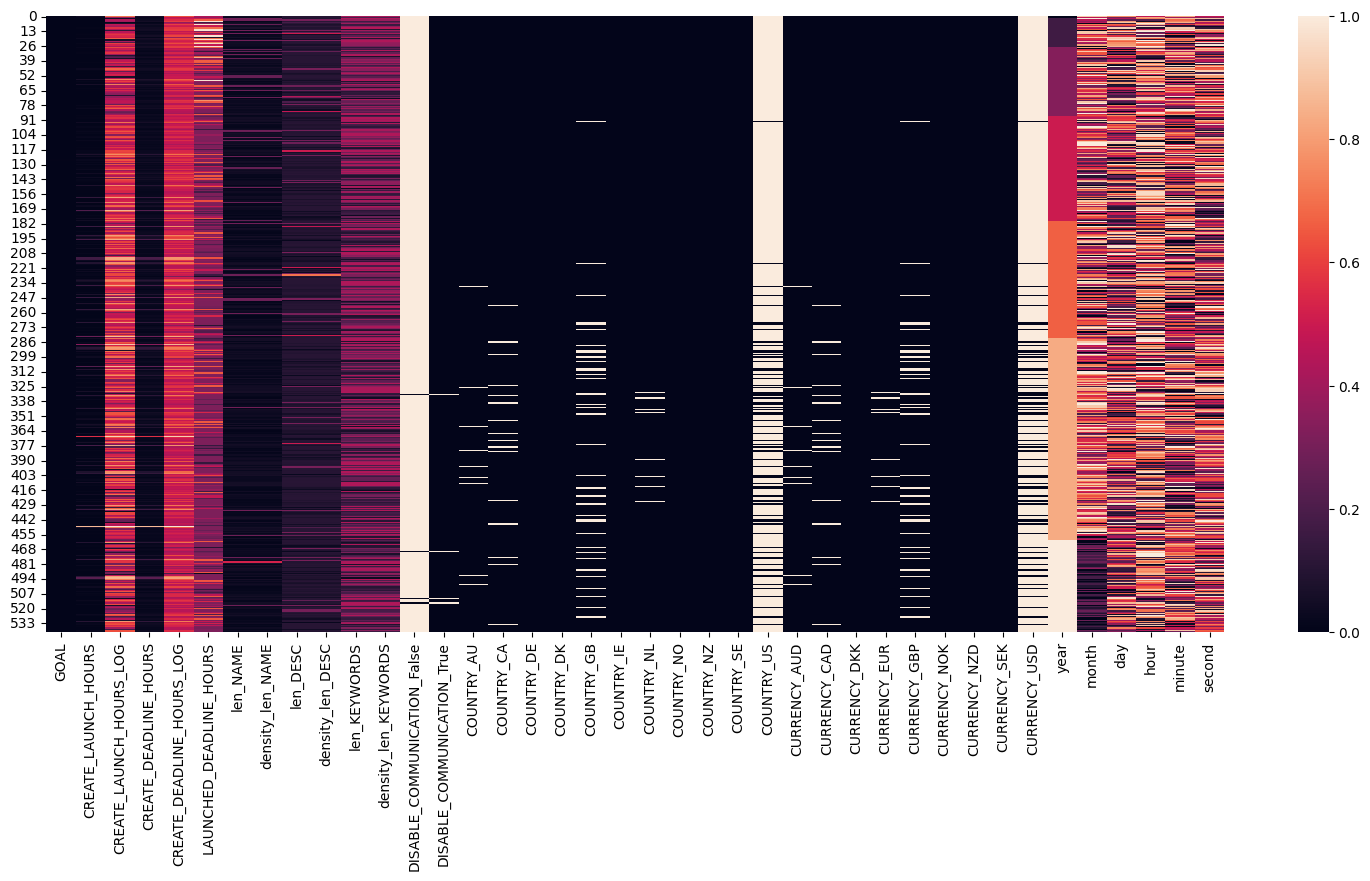

In [65]:
plt.figure(figsize=(19, 8))
sns.heatmap(df_dev_normalized_frac);

# Clustermap

/home/work/Dev/kickstarter/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


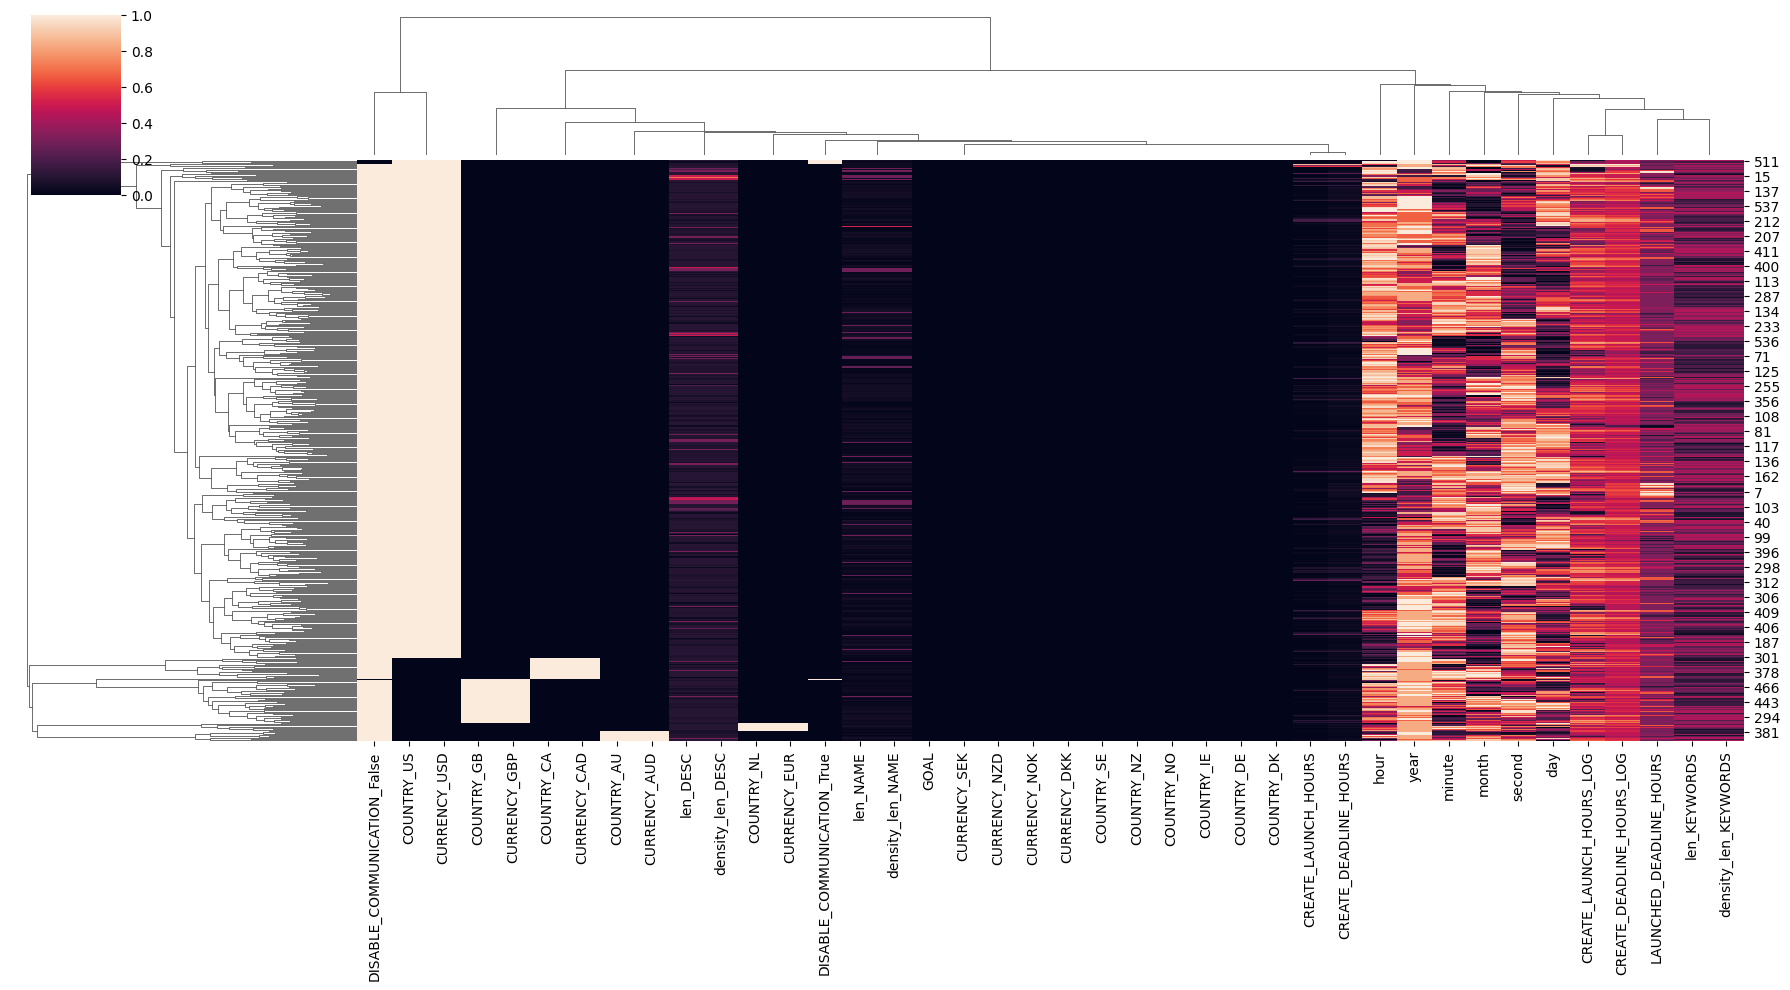

In [66]:
sns.clustermap(df_dev_normalized_frac, figsize=(18, 10));

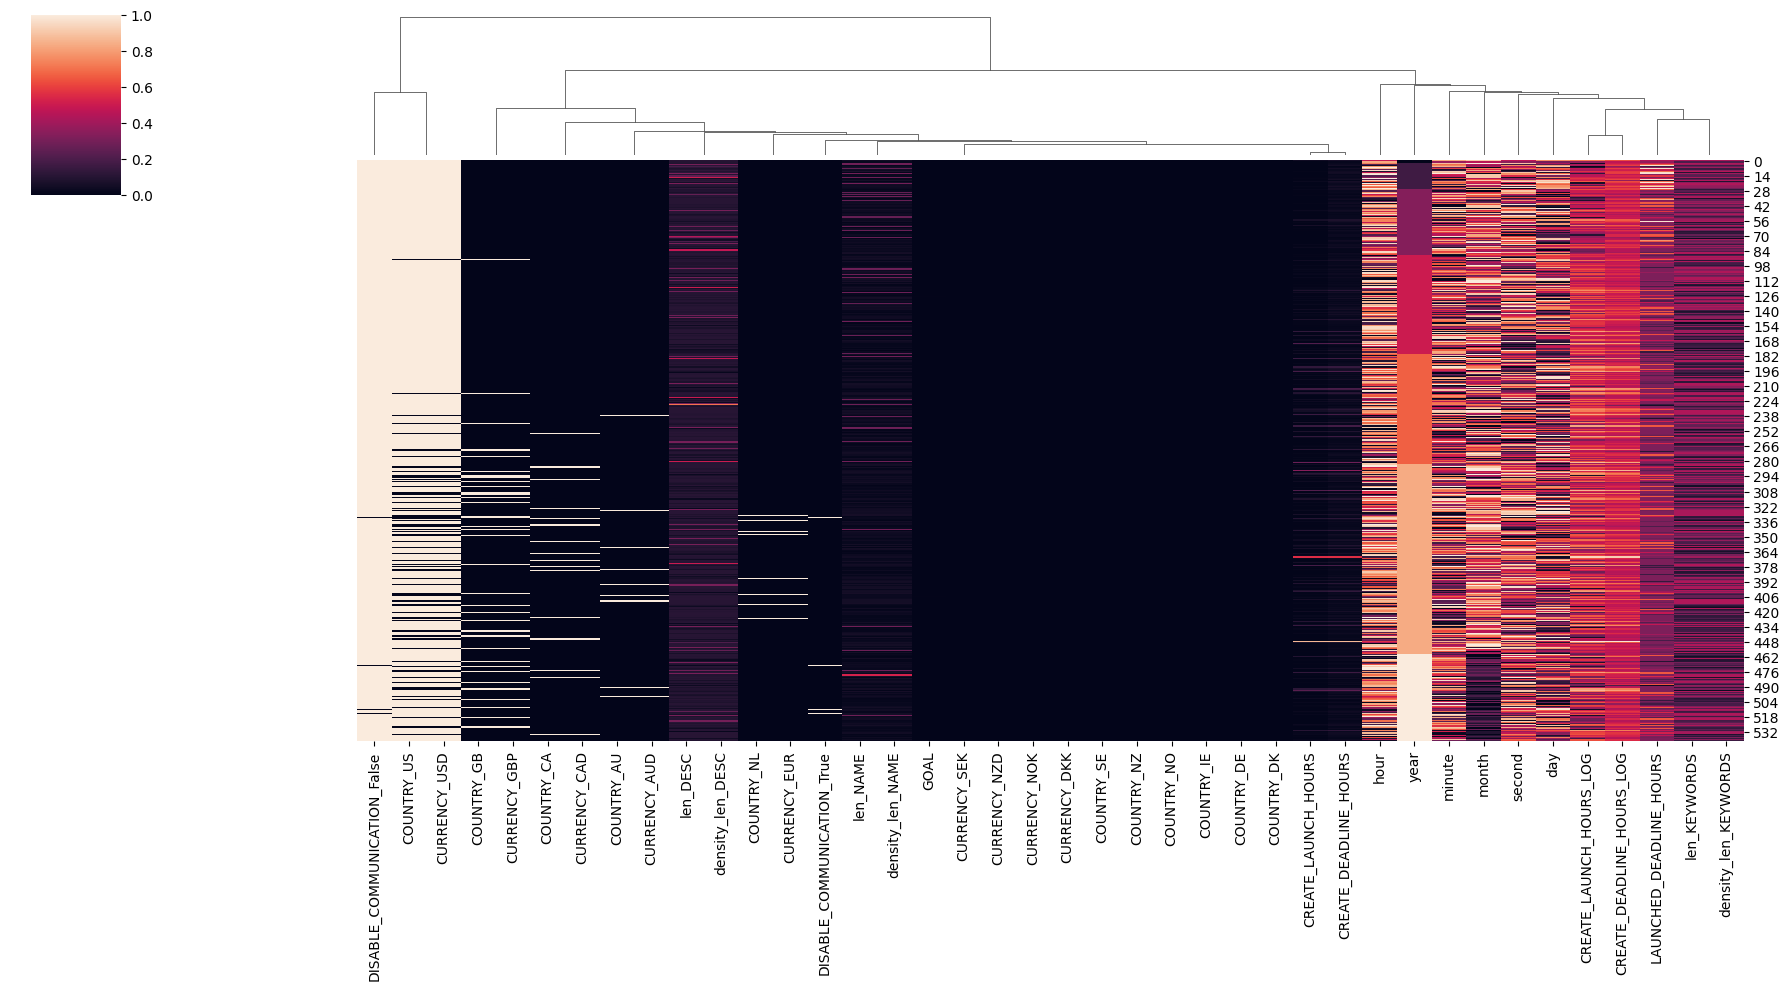

In [67]:
sns.clustermap(df_dev_normalized_frac, row_cluster=False, figsize=(18, 10));

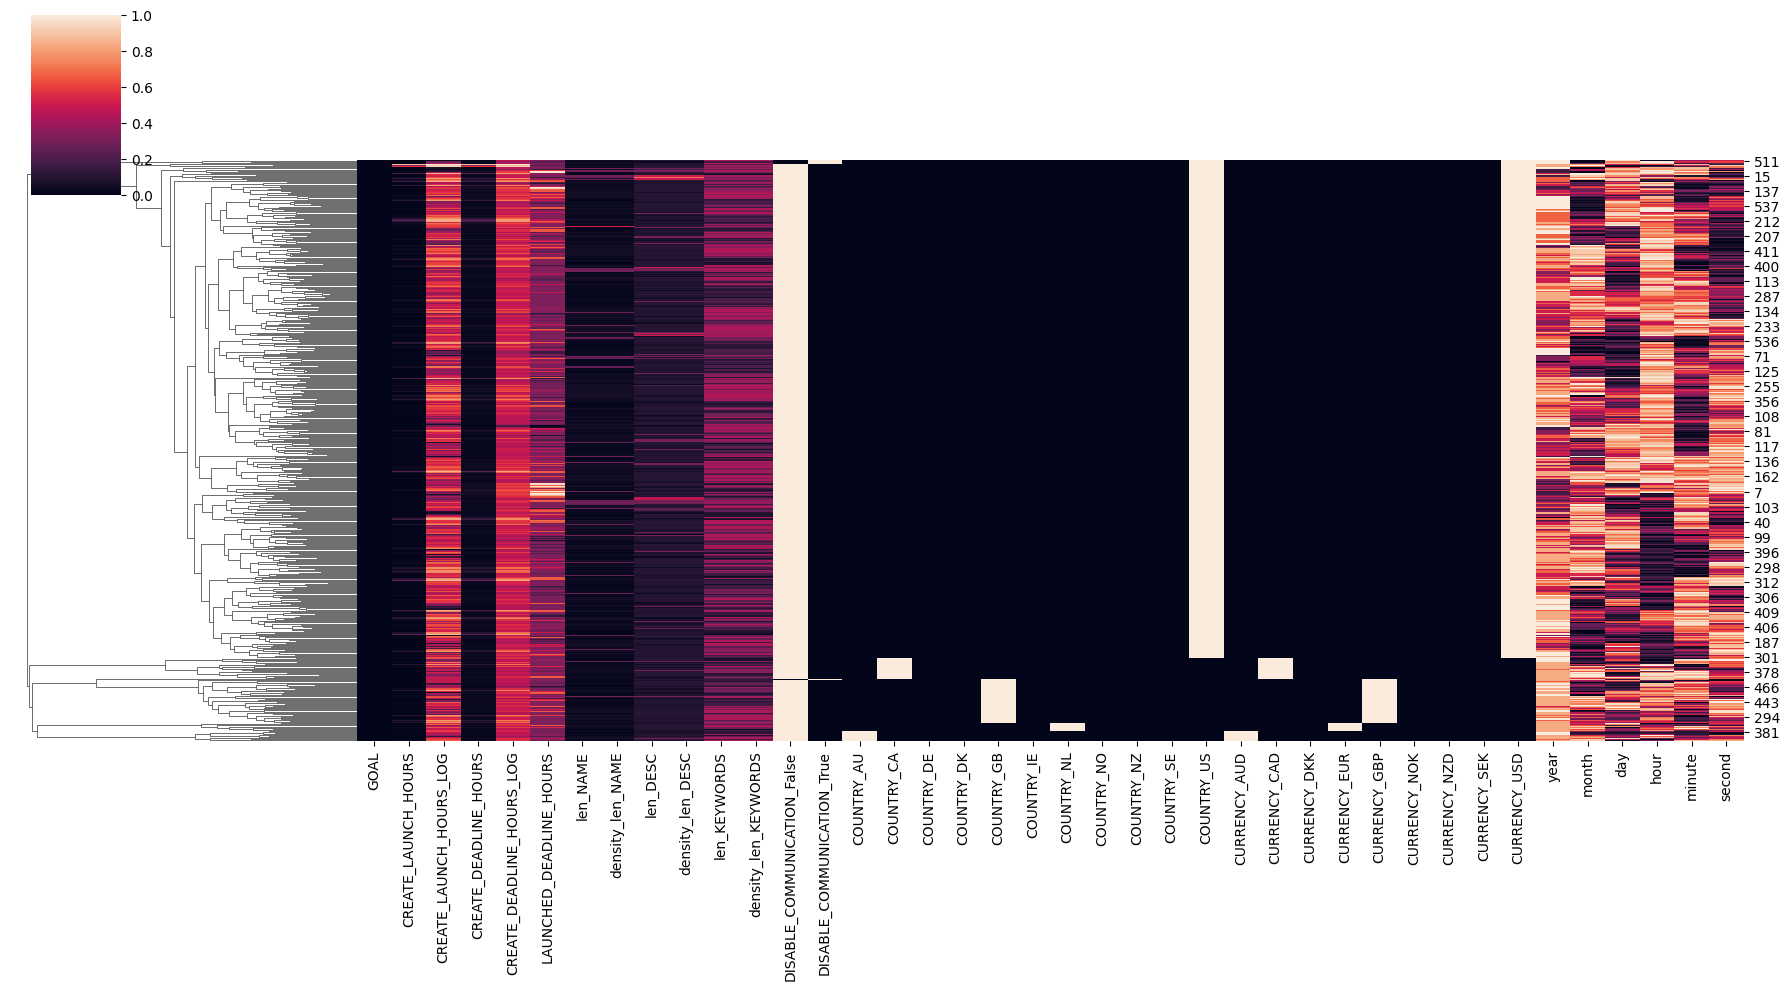

In [68]:
sns.clustermap(df_dev_normalized_frac, col_cluster=False, figsize=(18, 10));

# Agglomerative clustering

## Exploring `n_clusters`

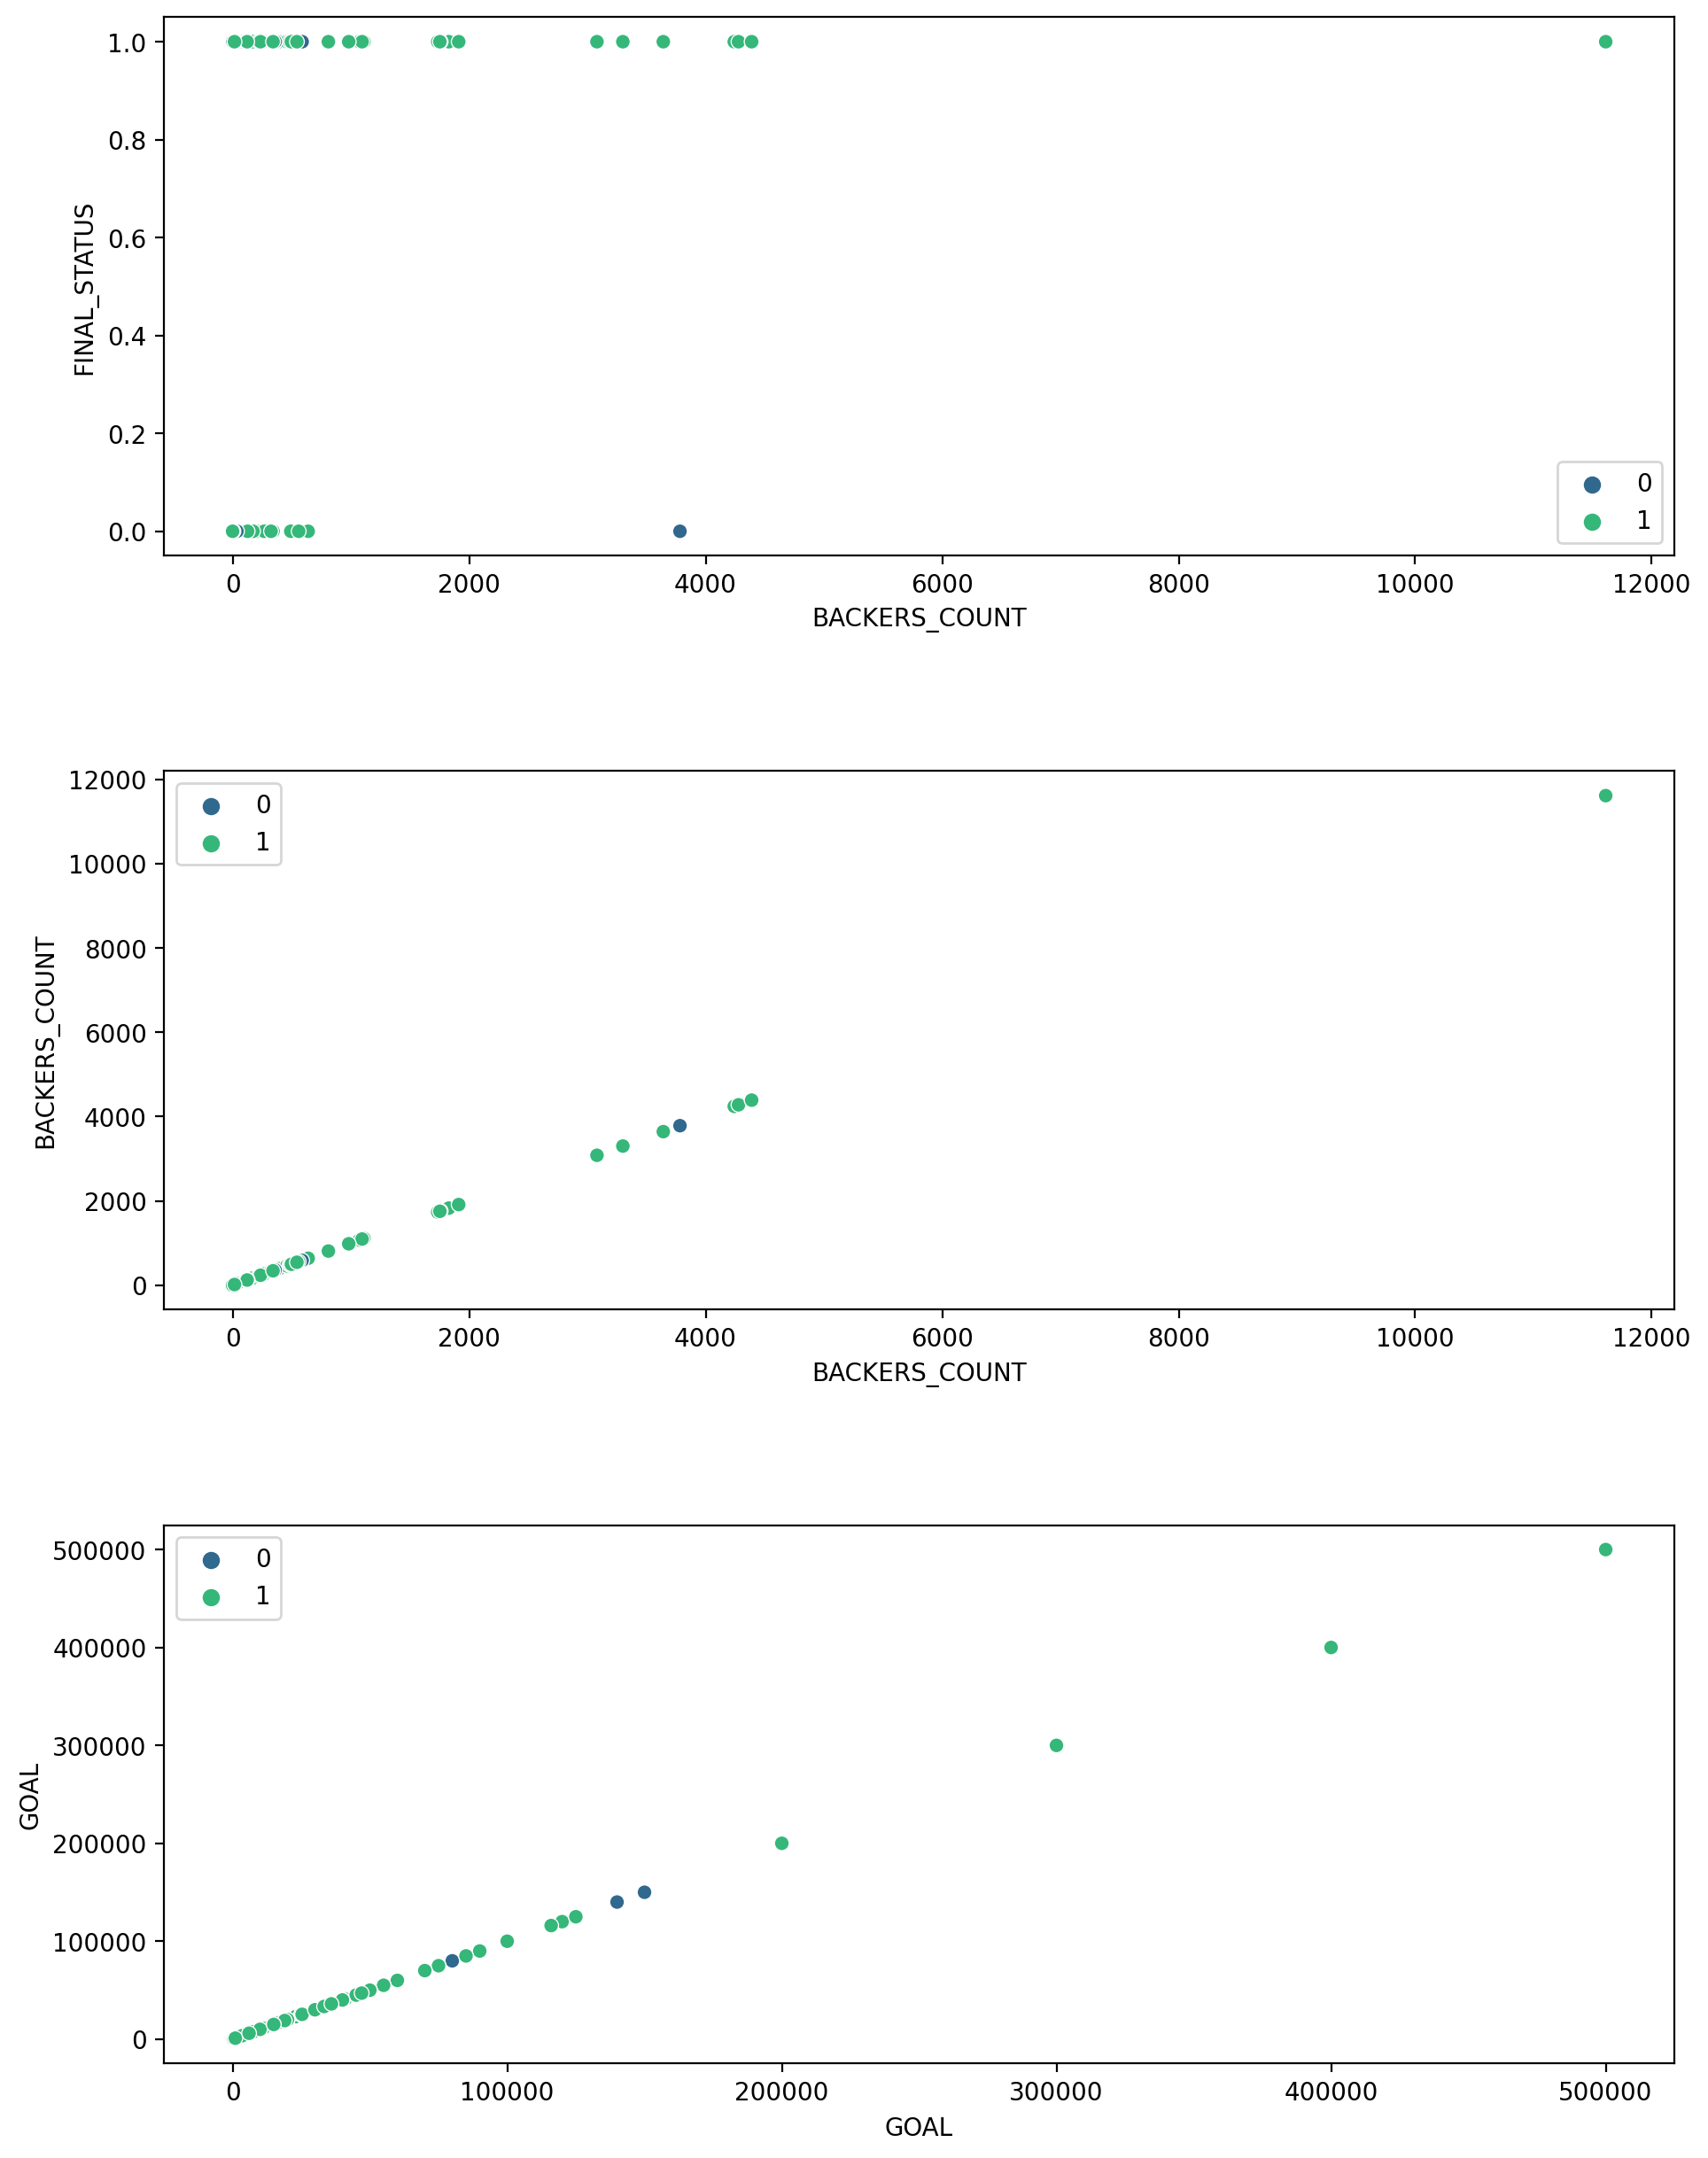

In [69]:
model = AgglomerativeClustering(n_clusters=2)
cluster_labels = model.fit_predict(df_dev_normalized_frac)

fig, axes = plt.subplots(3, 1, figsize=(11, 15), dpi=200)

sns.scatterplot(ax=axes[0], data=df_dev_raw_subsample, x='BACKERS_COUNT', y='FINAL_STATUS', hue=cluster_labels, palette='viridis')
sns.scatterplot(ax=axes[1], data=df_dev_raw_subsample, x='BACKERS_COUNT', y='BACKERS_COUNT', hue=cluster_labels, palette='viridis')
sns.scatterplot(ax=axes[2], data=df_dev_raw_subsample, x='GOAL', y='GOAL', hue=cluster_labels, palette='viridis')

plt.subplots_adjust(hspace=0.4)
plt.show()

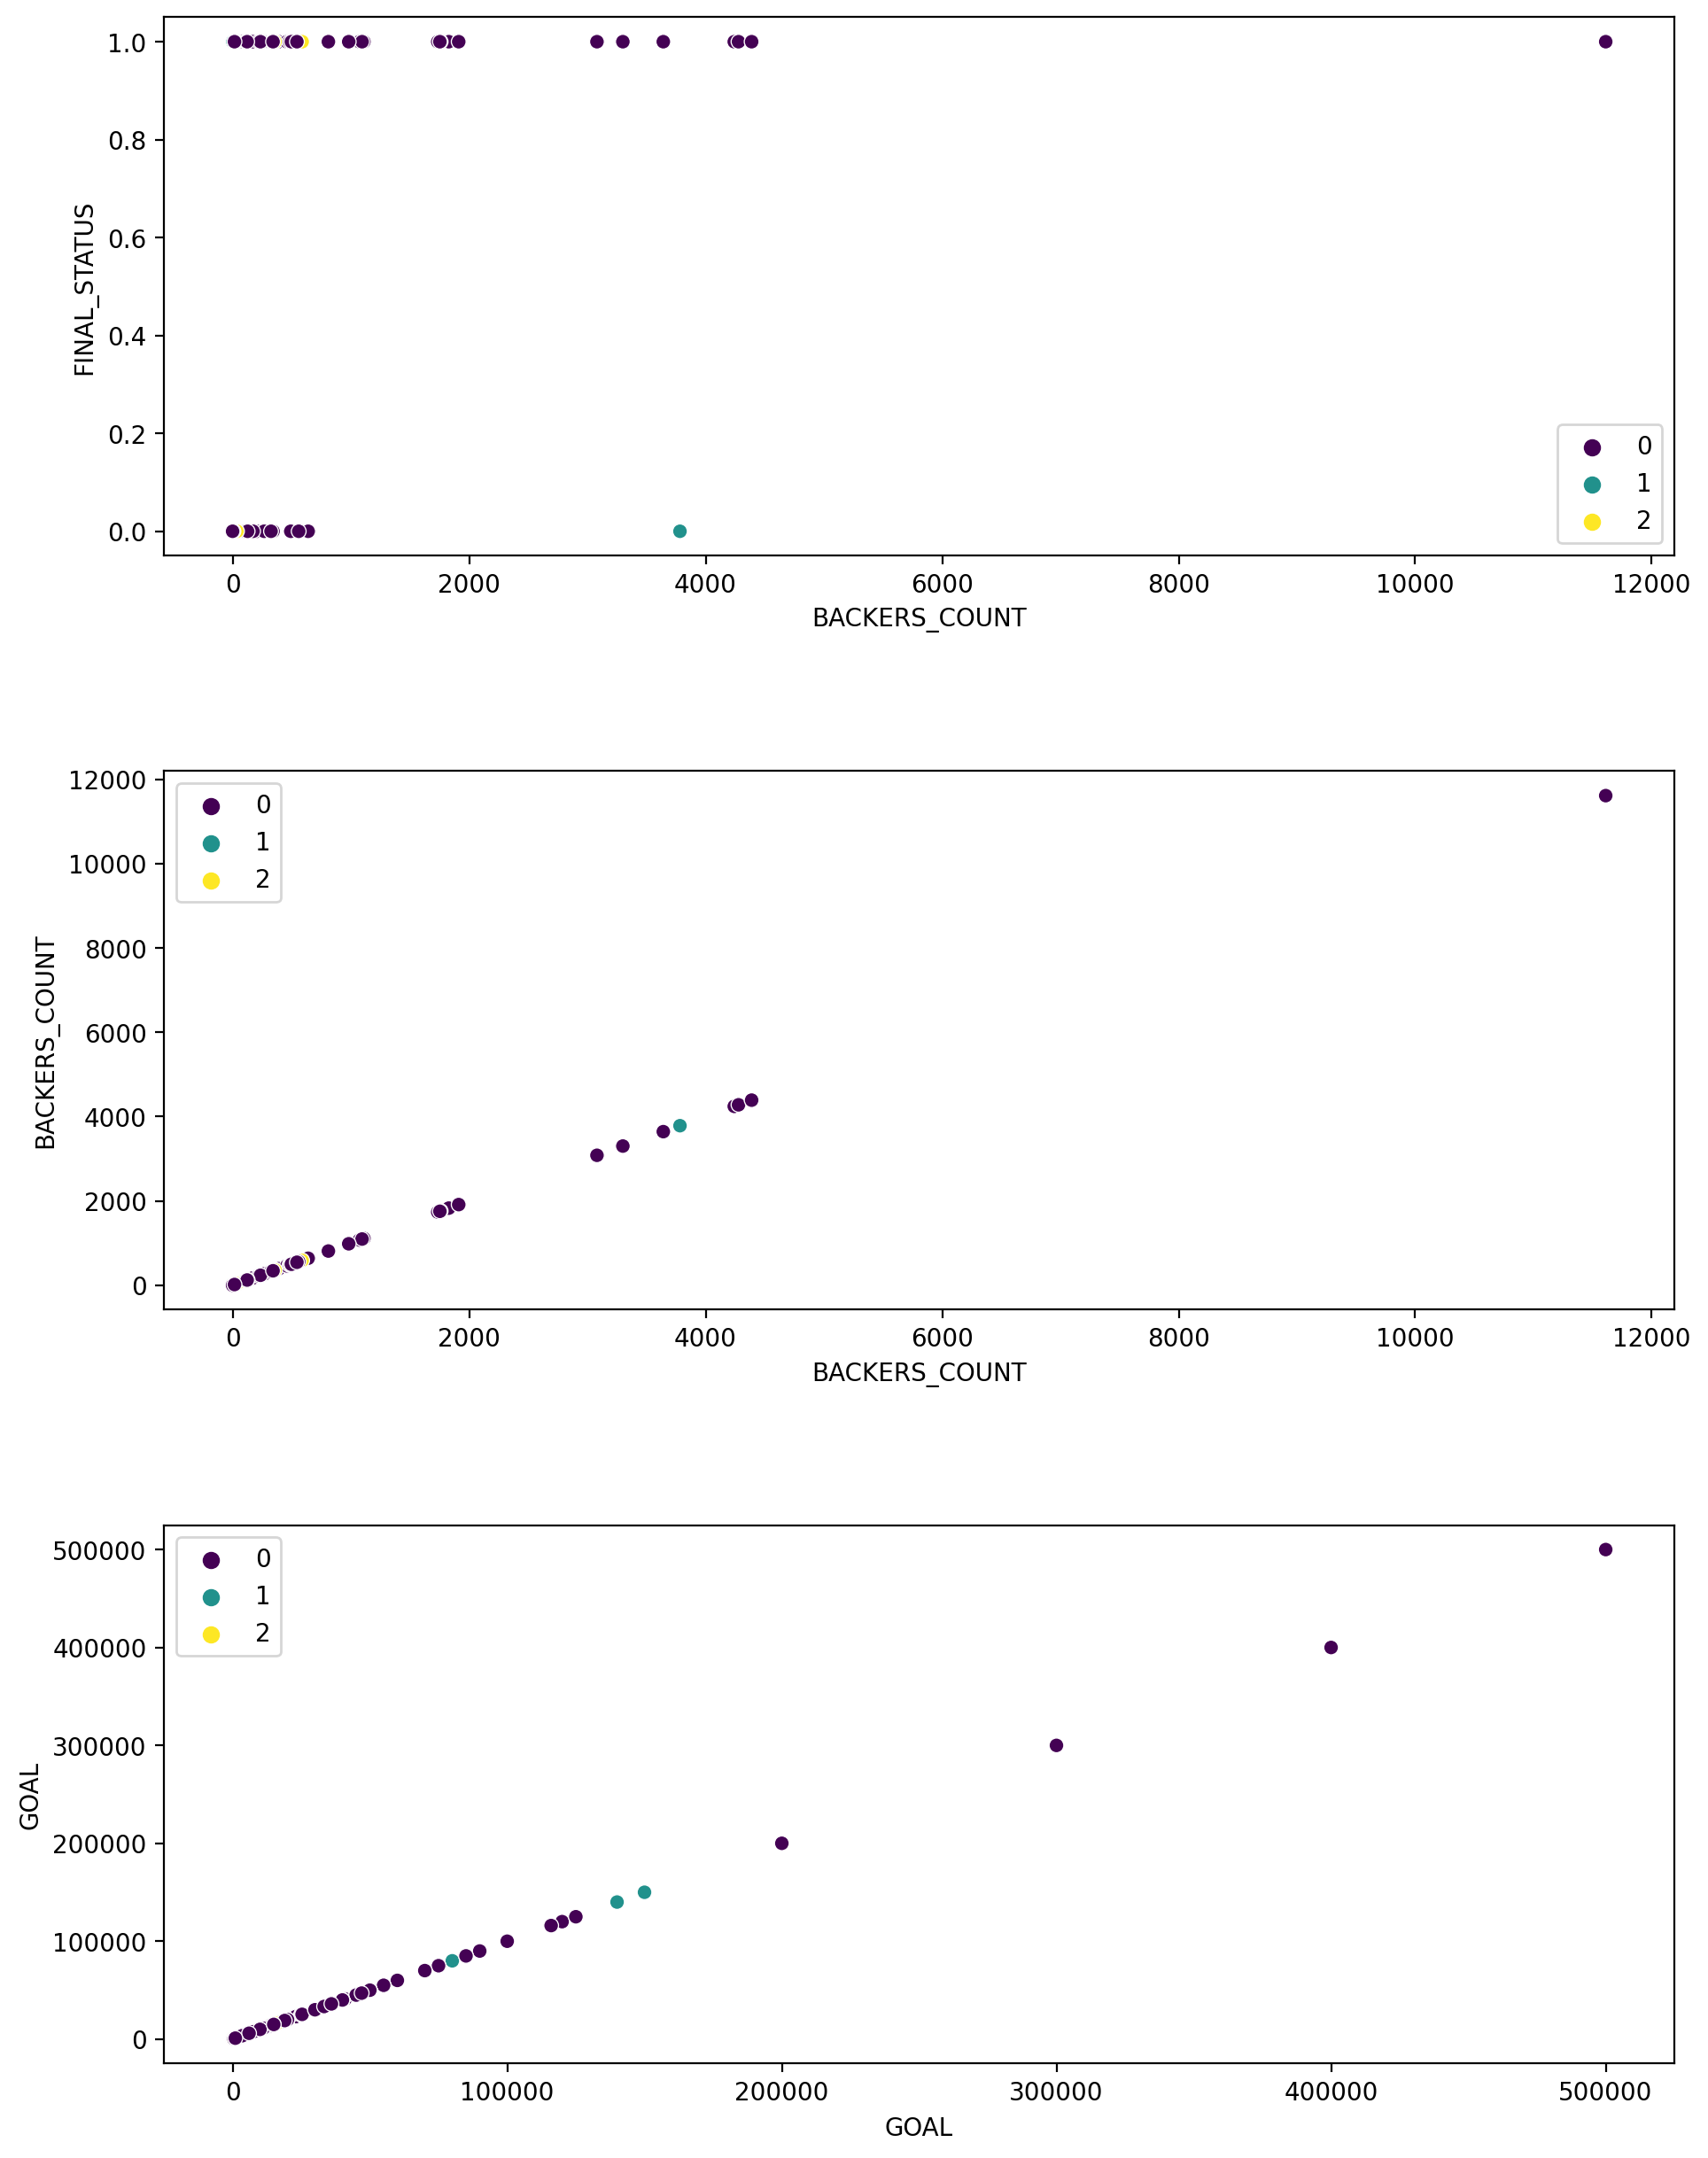

In [70]:
model = AgglomerativeClustering(n_clusters=3)
cluster_labels = model.fit_predict(df_dev_normalized_frac)

fig, axes = plt.subplots(3, 1, figsize=(11, 15), dpi=200)

sns.scatterplot(ax=axes[0], data=df_dev_raw_subsample, x='BACKERS_COUNT', y='FINAL_STATUS', hue=cluster_labels, palette='viridis')
sns.scatterplot(ax=axes[1], data=df_dev_raw_subsample, x='BACKERS_COUNT', y='BACKERS_COUNT', hue=cluster_labels, palette='viridis')
sns.scatterplot(ax=axes[2], data=df_dev_raw_subsample, x='GOAL', y='GOAL', hue=cluster_labels, palette='viridis')

plt.subplots_adjust(hspace=0.4)
plt.show()

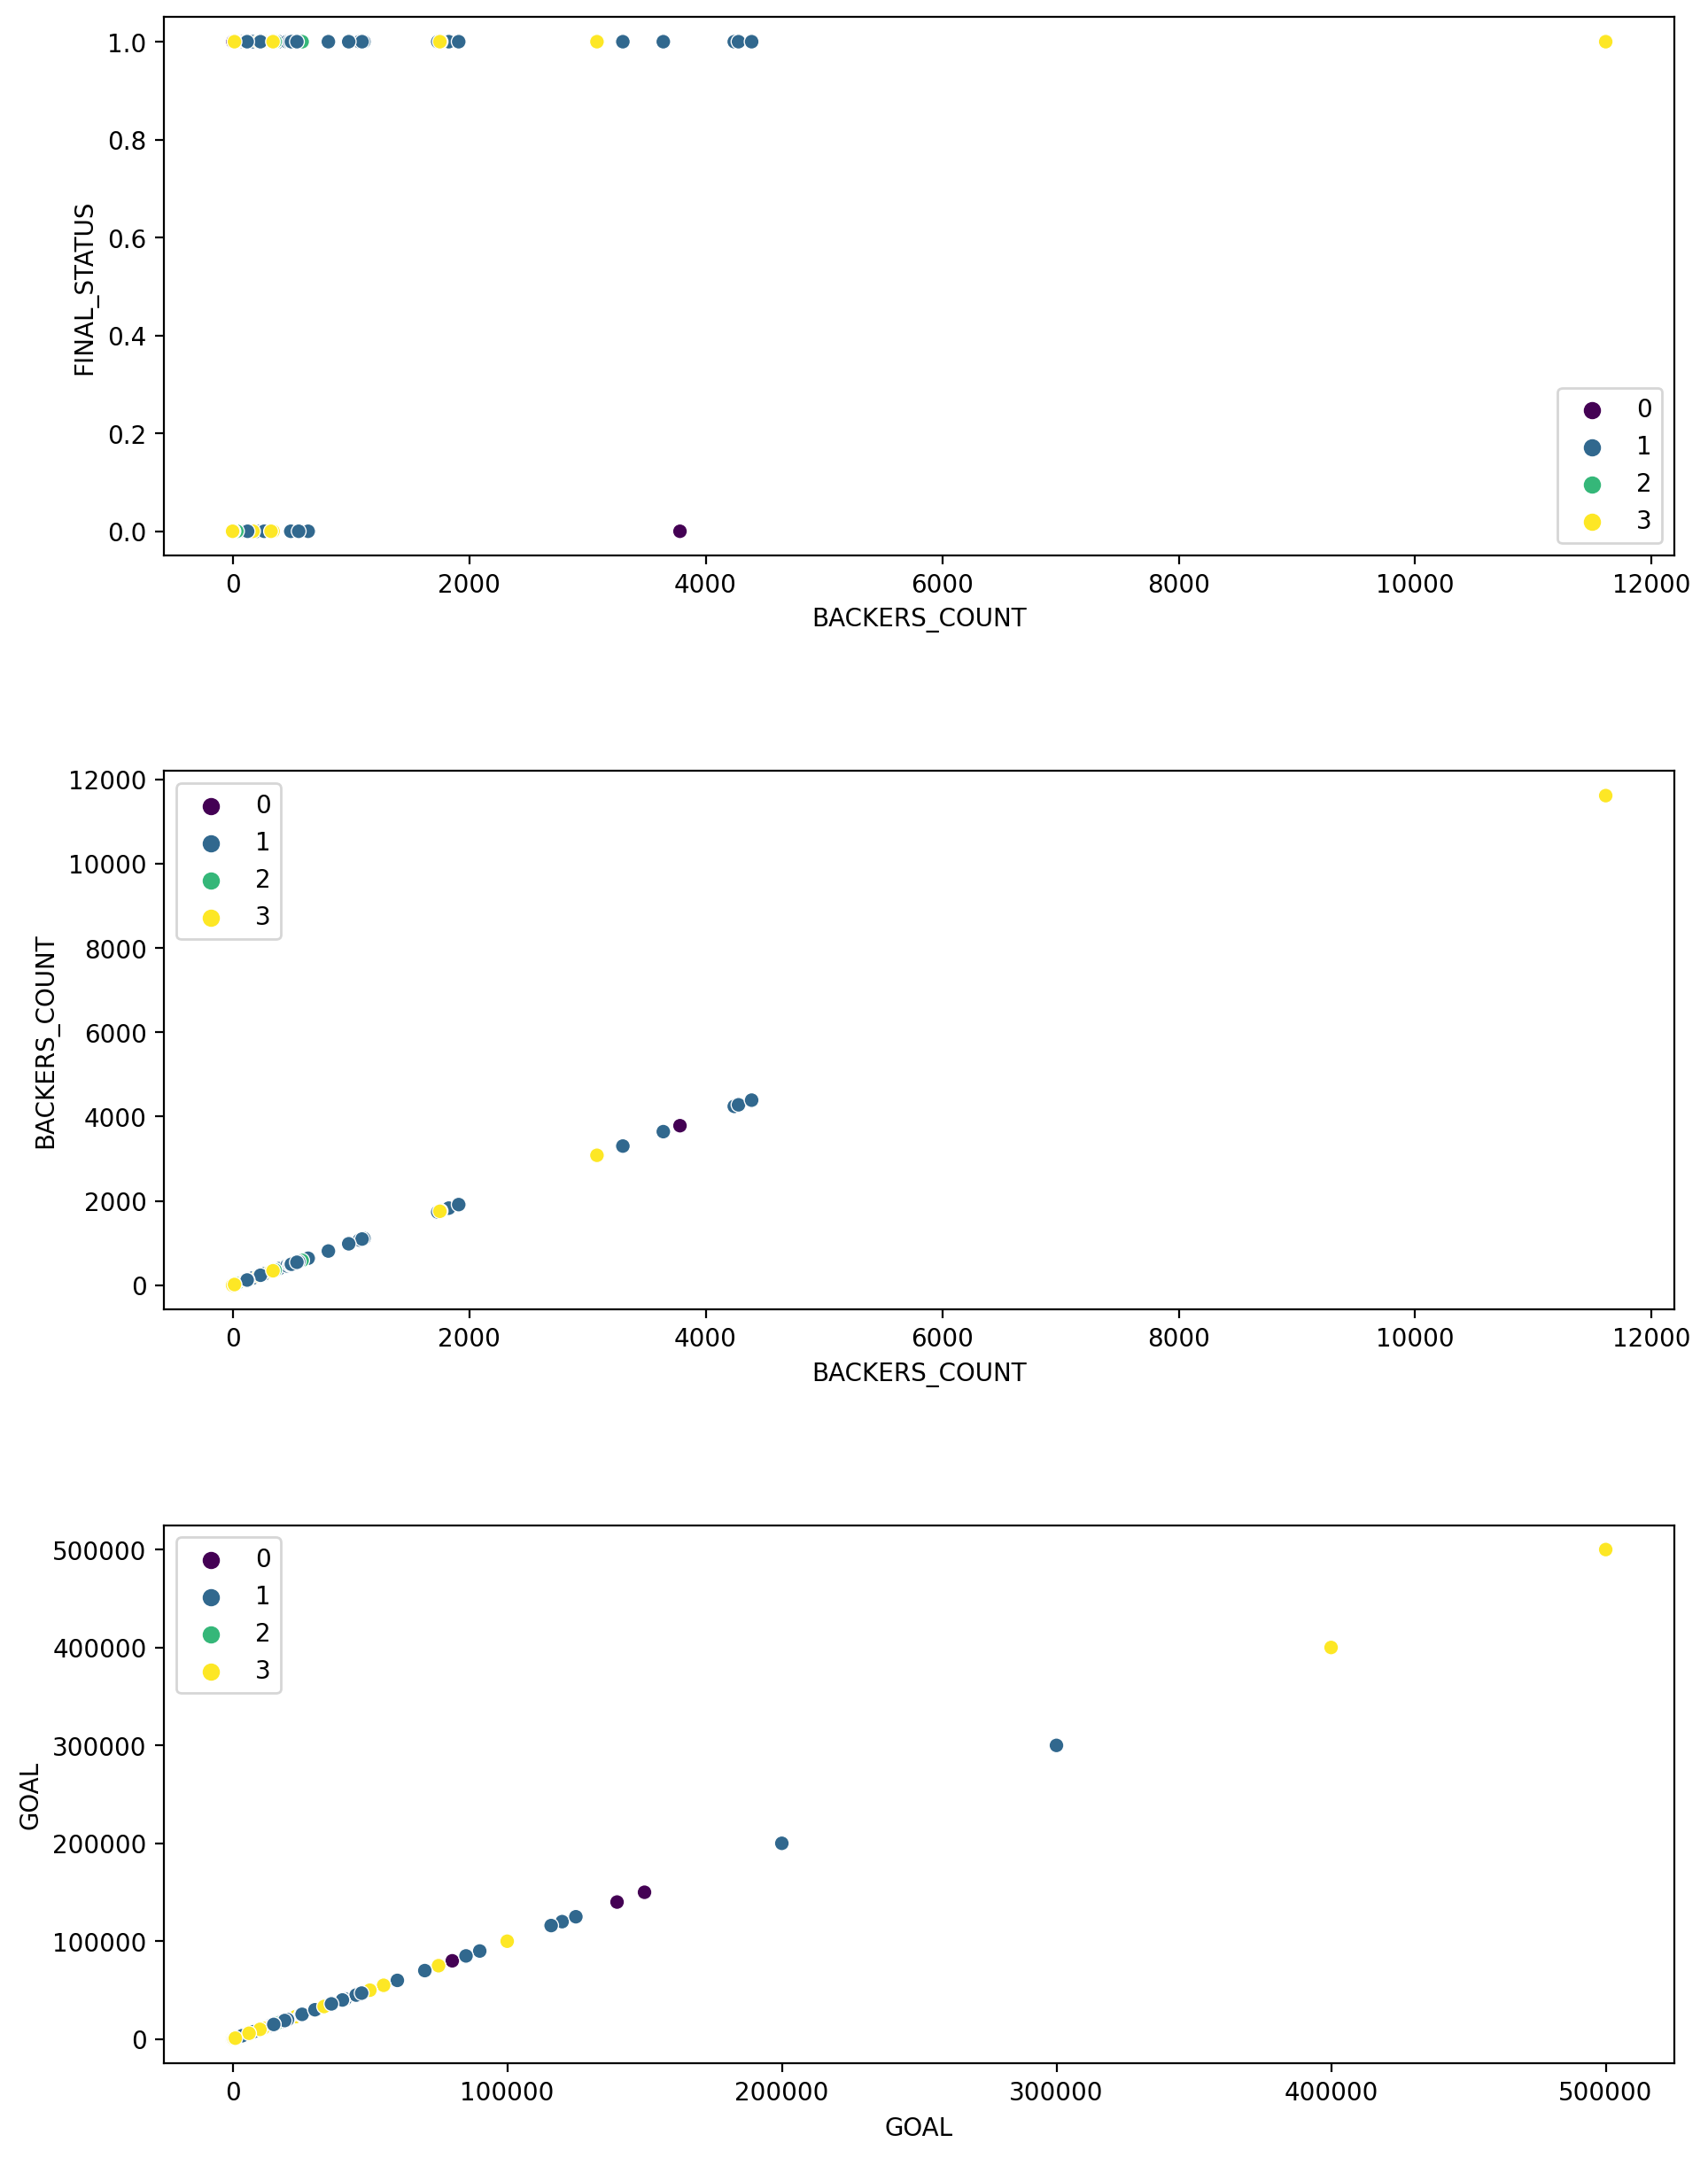

In [71]:
model = AgglomerativeClustering(n_clusters=4)
cluster_labels = model.fit_predict(df_dev_normalized_frac)

fig, axes = plt.subplots(3, 1, figsize=(11, 15), dpi=200)

sns.scatterplot(ax=axes[0], data=df_dev_raw_subsample, x='BACKERS_COUNT', y='FINAL_STATUS', hue=cluster_labels, palette='viridis')
sns.scatterplot(ax=axes[1], data=df_dev_raw_subsample, x='BACKERS_COUNT', y='BACKERS_COUNT', hue=cluster_labels, palette='viridis')
sns.scatterplot(ax=axes[2], data=df_dev_raw_subsample, x='GOAL', y='GOAL', hue=cluster_labels, palette='viridis')

plt.subplots_adjust(hspace=0.4)
plt.show()

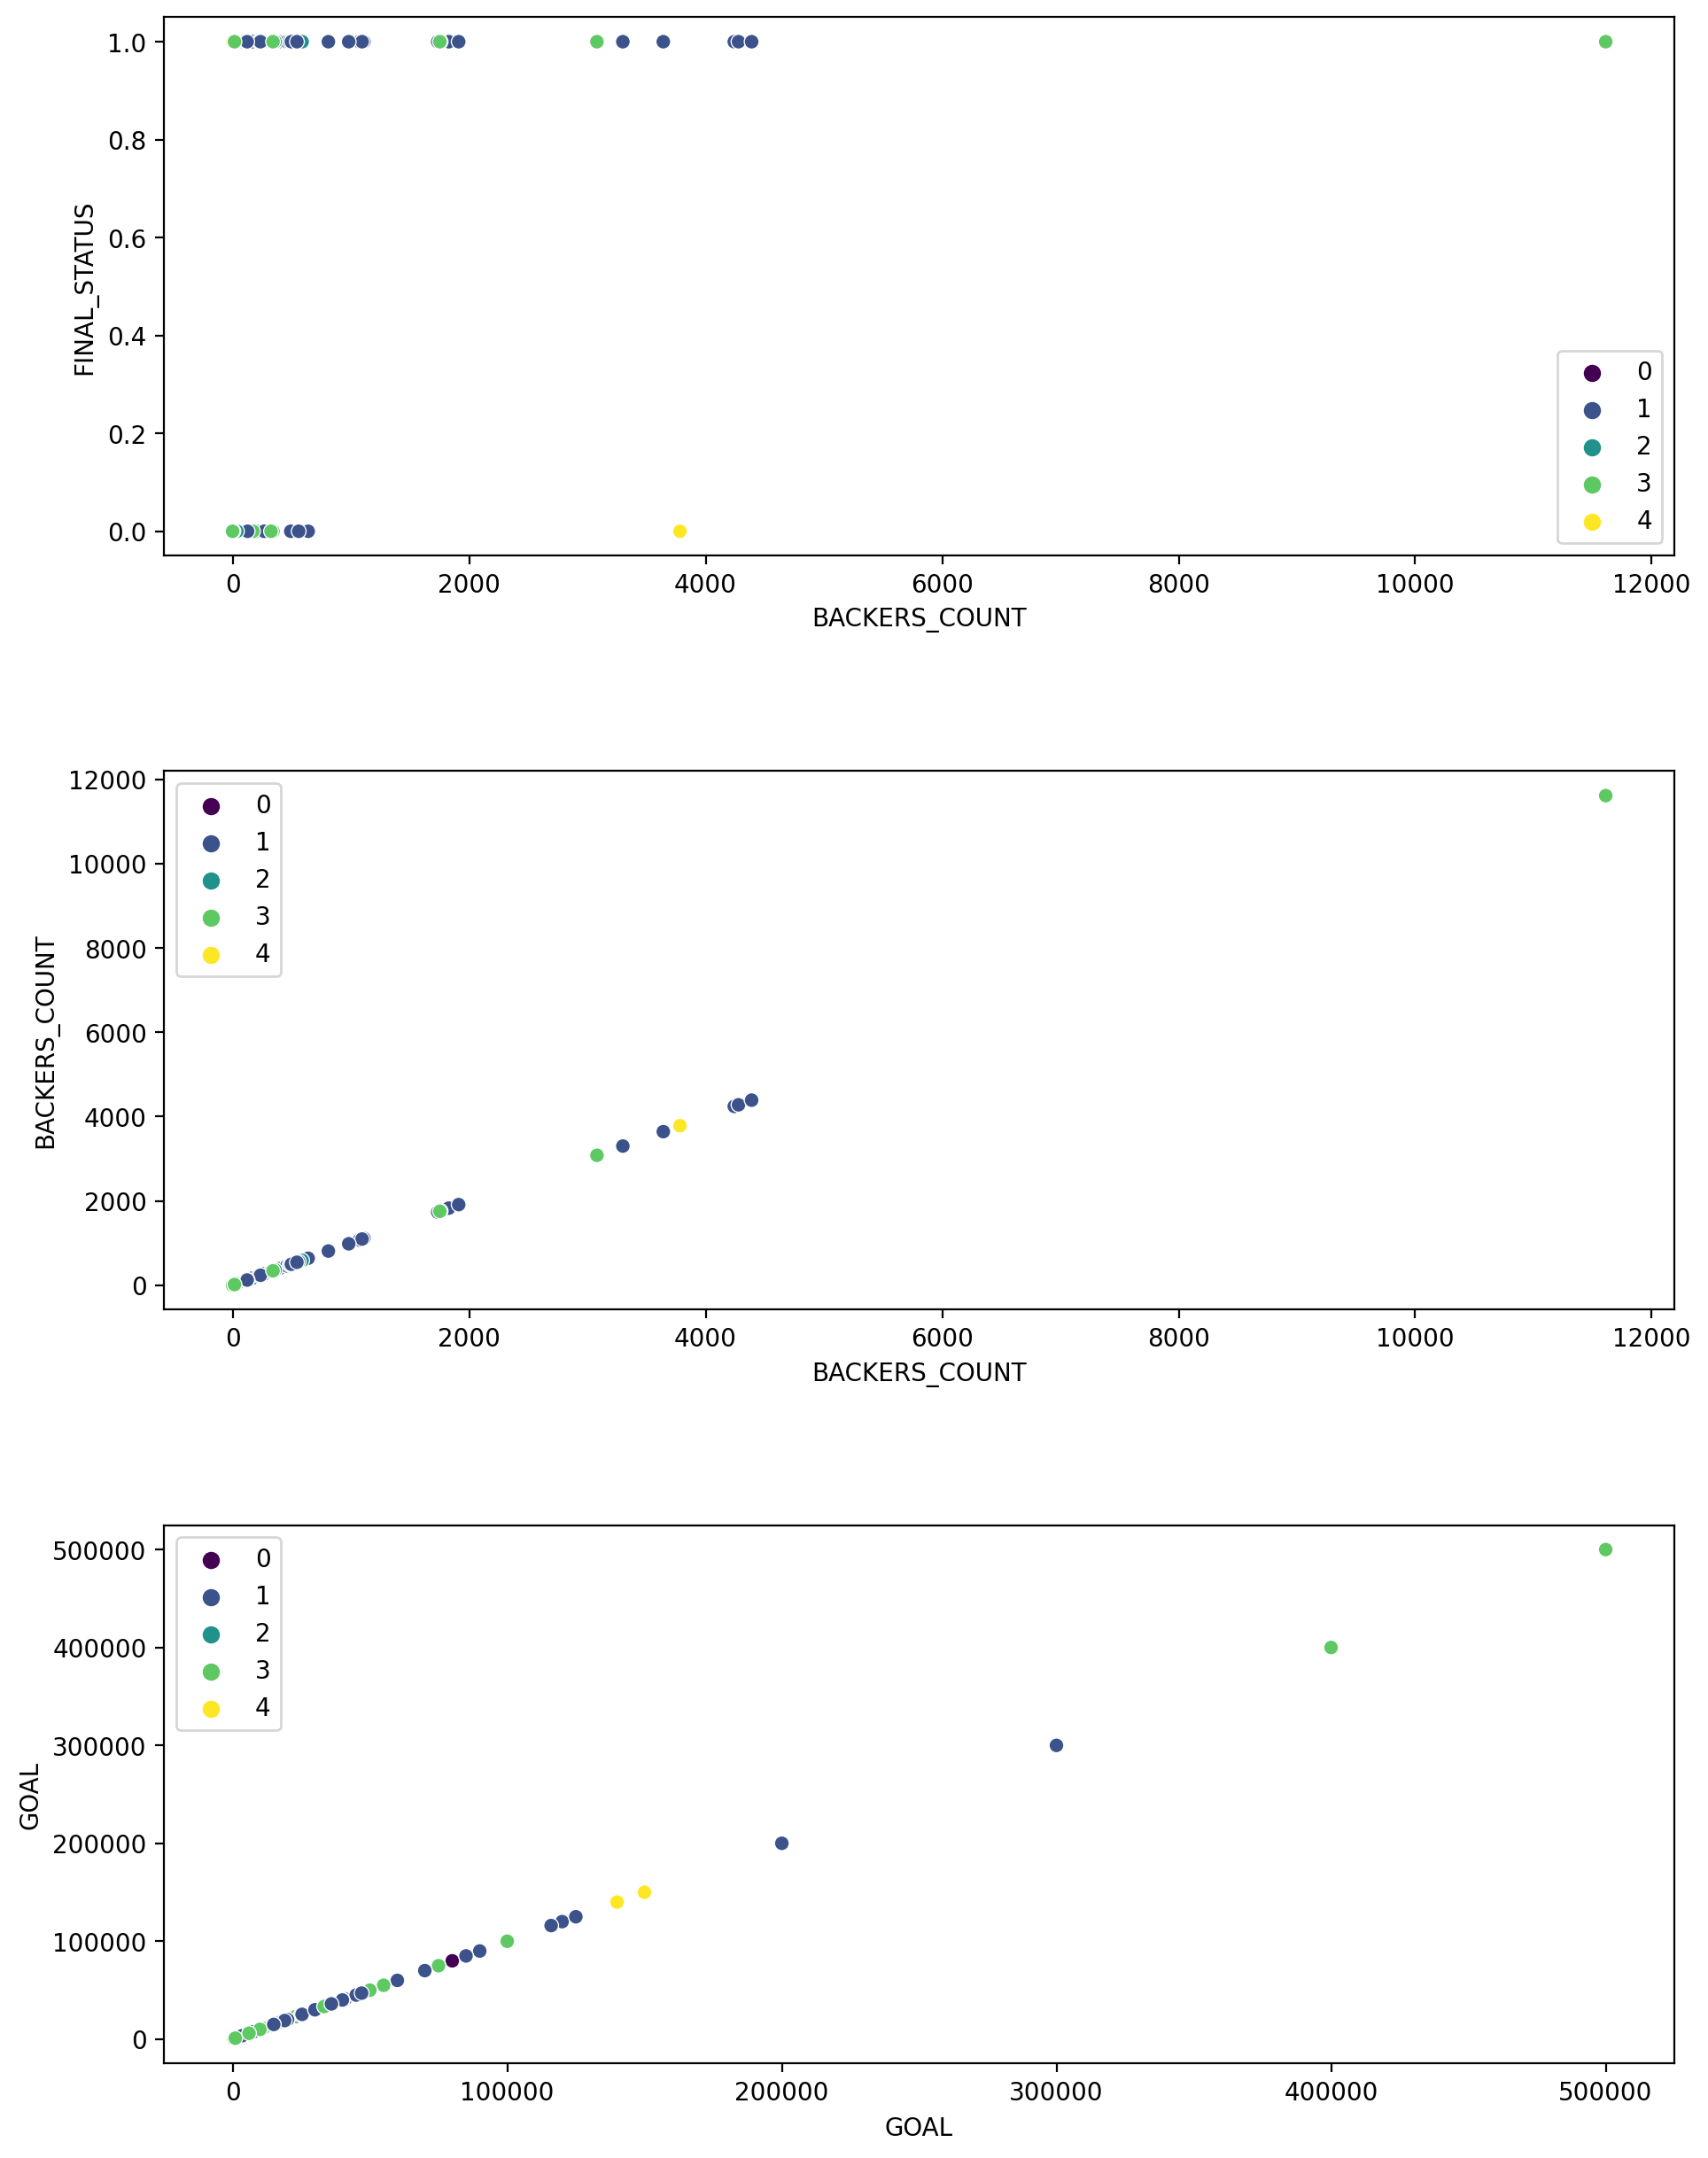

In [72]:
model = AgglomerativeClustering(n_clusters=5)
cluster_labels = model.fit_predict(df_dev_normalized_frac)

fig, axes = plt.subplots(3, 1, figsize=(11, 15), dpi=200)

sns.scatterplot(ax=axes[0], data=df_dev_raw_subsample, x='BACKERS_COUNT', y='FINAL_STATUS', hue=cluster_labels, palette='viridis')
sns.scatterplot(ax=axes[1], data=df_dev_raw_subsample, x='BACKERS_COUNT', y='BACKERS_COUNT', hue=cluster_labels, palette='viridis')
sns.scatterplot(ax=axes[2], data=df_dev_raw_subsample, x='GOAL', y='GOAL', hue=cluster_labels, palette='viridis')

plt.subplots_adjust(hspace=0.4)
plt.show()

# Outlier detection

In [73]:
outlier_percentage = []
ps = np.linspace(0.001, 3, 200)

for eps in ps:
    dbscan = DBSCAN(eps=eps, min_samples=2*df_dev_normalized_frac.shape[1])
    dbscan.fit(df_dev_normalized_frac)
    
    perc_outliers = 100 * np.sum(dbscan.labels_==-1) / len(dbscan.labels_)
    outlier_percentage.append(perc_outliers)
    print(f'{eps=} | {perc_outliers=}')

eps=0.001 | perc_outliers=100.0
eps=0.01607035175879397 | perc_outliers=100.0
eps=0.03114070351758794 | perc_outliers=100.0
eps=0.04621105527638191 | perc_outliers=100.0
eps=0.06128140703517588 | perc_outliers=100.0
eps=0.07635175879396985 | perc_outliers=100.0
eps=0.09142211055276382 | perc_outliers=100.0
eps=0.10649246231155779 | perc_outliers=100.0
eps=0.12156281407035176 | perc_outliers=100.0
eps=0.13663316582914573 | perc_outliers=100.0
eps=0.1517035175879397 | perc_outliers=100.0
eps=0.16677386934673366 | perc_outliers=100.0
eps=0.18184422110552764 | perc_outliers=100.0
eps=0.1969145728643216 | perc_outliers=100.0
eps=0.21198492462311558 | perc_outliers=100.0
eps=0.22705527638190953 | perc_outliers=100.0
eps=0.2421256281407035 | perc_outliers=100.0
eps=0.2571959798994975 | perc_outliers=100.0
eps=0.27226633165829145 | perc_outliers=100.0
eps=0.2873366834170854 | perc_outliers=100.0
eps=0.3024070351758794 | perc_outliers=100.0
eps=0.31747738693467337 | perc_outliers=100.0
eps=0.33

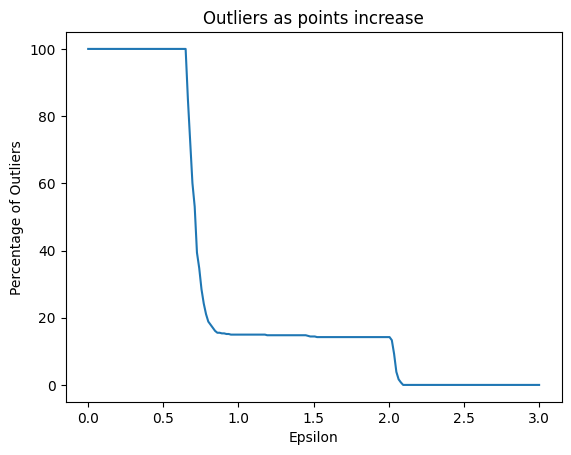

In [74]:
sns.lineplot(x=ps, y=outlier_percentage)
plt.title('Outliers as points increase')
plt.xlabel('Epsilon')
plt.ylabel('Percentage of Outliers')
plt.show()

In [75]:
dbscan = DBSCAN(eps=0.78, min_samples=df_dev_normalized_frac.shape[1])
dbscan.fit(df_dev_normalized_frac)

DBSCAN(eps=0.78, min_samples=40)

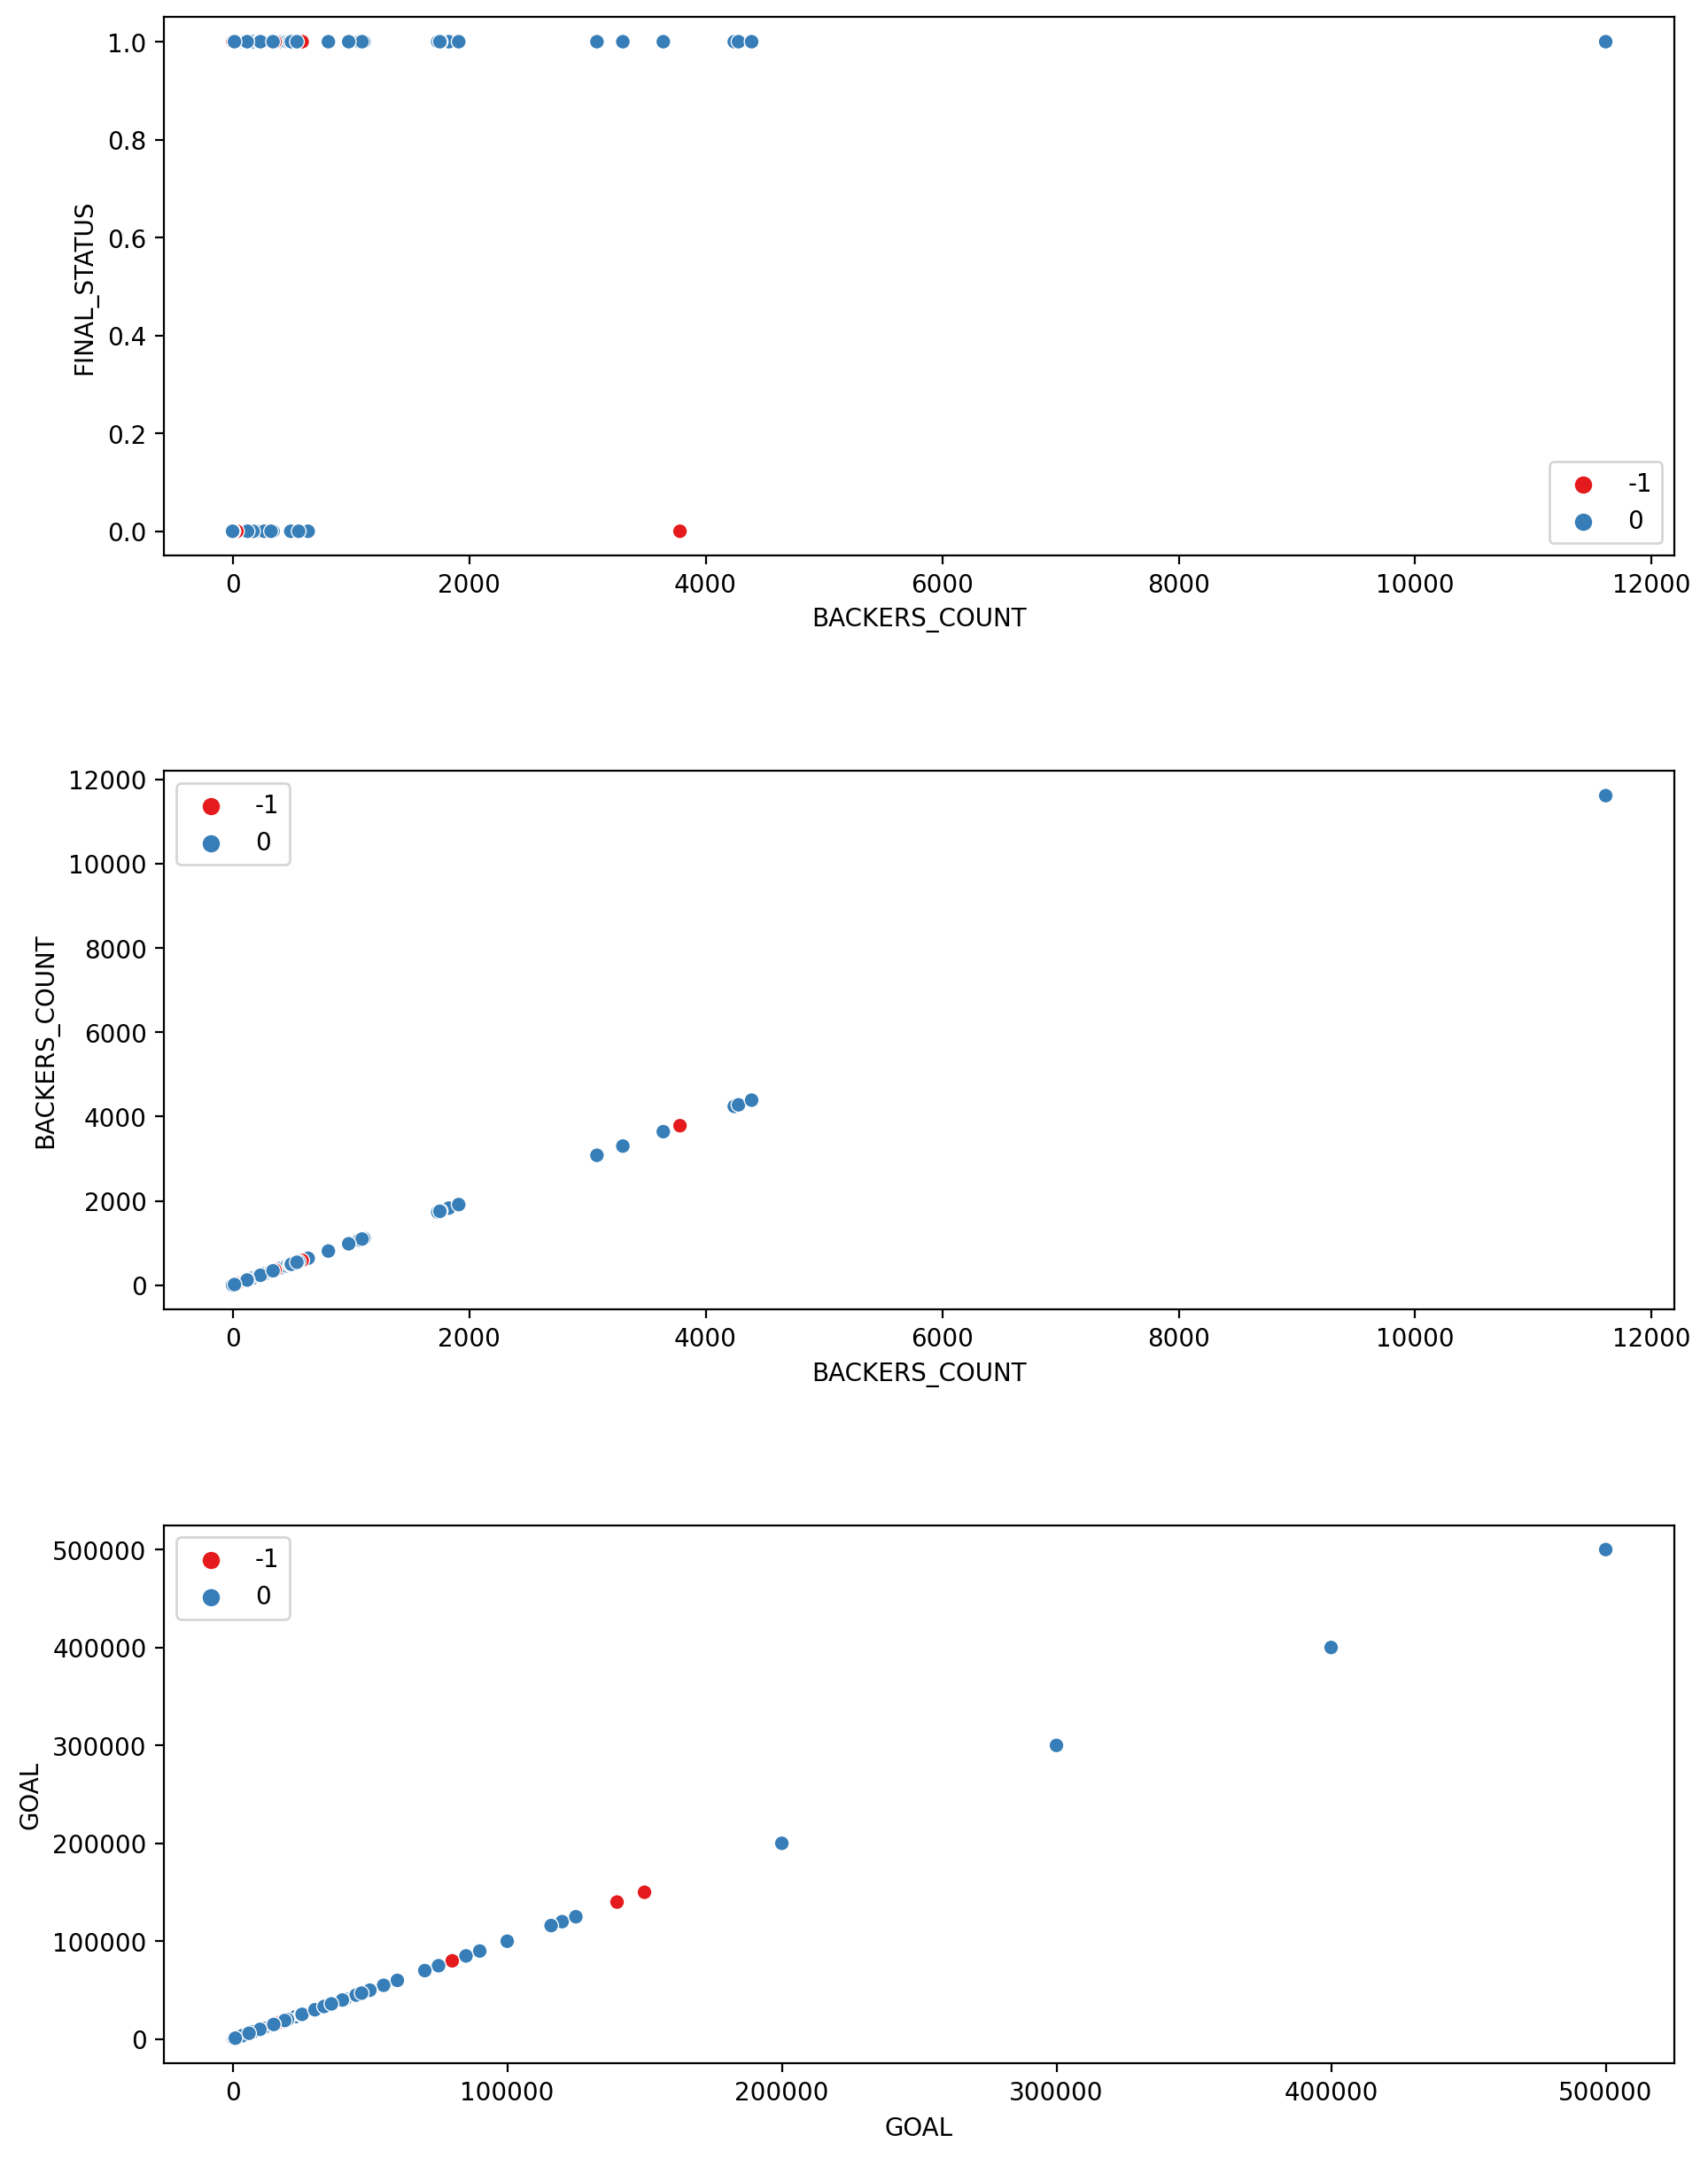

In [76]:
fig, axes = plt.subplots(3, 1, figsize=(11, 15), dpi=200)

sns.scatterplot(ax=axes[0], data=df_dev_raw_subsample, x='BACKERS_COUNT', y='FINAL_STATUS', hue=dbscan.labels_, palette='Set1')
sns.scatterplot(ax=axes[1], data=df_dev_raw_subsample, x='BACKERS_COUNT', y='BACKERS_COUNT', hue=dbscan.labels_, palette='Set1')
sns.scatterplot(ax=axes[2], data=df_dev_raw_subsample, x='GOAL', y='GOAL', hue=dbscan.labels_, palette='Set1')

plt.subplots_adjust(hspace=0.4)
plt.show()

In [77]:
df_dev_raw_subsample = df_dev_raw_subsample.assign(Labels=dbscan.labels_)
df_dev_raw_subsample

,PROJECT_ID,NAME,DESC,GOAL,KEYWORDS,DISABLE_COMMUNICATION,COUNTRY,CURRENCY,DEADLINE,STATE_CHANGED_AT,...,LAUNCHED_AT,BACKERS_COUNT,FINAL_STATUS,CREATE_LAUNCH_HOURS,CREATE_LAUNCH_HOURS_LOG,CREATE_DEADLINE_HOURS,CREATE_DEADLINE_HOURS_LOG,LAUNCHED_DEADLINE_HOURS,TRAIN_VAL_TEST_SPLIT,Labels
28863,kkst1319470138,Let's build the Louisiana Resource Guide toget...,Together we can build the Louisiana Resource G...,4500.0,lets-build-the-louisiana-resource-guide-together,False,US,USD,2010-01-04 09:59:00,2010-01-04 10:00:08,...,2009-11-24 11:49:28,9,0,1961.369444,7.581908,2943.528333,7.987704,982.158889,Train,0
65957,kkst1659244608,Put Gareth Asher on Tour!,Hello internet friends! I have recorded a new...,2000.0,put-gareth-asher-on-tour,False,US,USD,2009-07-15 03:59:00,2009-07-15 04:01:00,...,2009-06-10 19:23:21,59,1,48.421944,3.900395,873.016111,6.773099,824.594167,Train,0
88638,kkst1592072348,"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""...",“The Artist's Process” is a Web Series as a TV...,999.0,the-artists-process-eps-3-webisode-as-a-tv-sho...,False,US,USD,2011-01-30 08:00:00,2011-01-30 08:00:15,...,2010-12-14 17:52:53,0,0,0.660833,0.507319,1118.779444,7.020887,1118.118611,Validation,0
4663,kkst612397262,"Calgar C wants to finish """"""""""""""""""""""""""""""""""""""""""...",I am a dj and producer going by the name of Ca...,3500.0,calgar-c-wants-to-finish-decade-trance-album,False,US,USD,2010-08-08 09:59:00,2010-08-08 10:00:07,...,2010-06-08 05:41:10,2,0,103.020833,4.644591,1571.318056,7.360306,1468.297222,Train,0
82575,kkst1545762768,Let There Be Letters!,"NEW GOAL: $100, with new rewards. All the litt...",50.0,let-there-be-letters,False,US,USD,2010-08-23 01:40:00,2010-08-23 01:45:08,...,2010-05-25 01:44:44,26,1,73.800556,4.314825,2233.721667,7.711872,2159.921111,Train,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45695,kkst147396532,Bad Decisions,"Amuse yourself, your friends, and everyone you...",10000.0,bad-decisions-0,False,US,USD,2015-04-05 23:01:19,2015-04-05 23:01:21,...,2015-03-07 00:01:19,113,1,533.991111,6.282250,1252.991111,7.134087,719.000000,Train,0
32159,kkst1179706120,Age of Valor: Heritage - The Audio Drama,"Just like the good old fashioned radio dramas,...",3500.0,age-of-valor-heritage-the-audio-drama,False,US,USD,2015-03-24 03:59:00,2015-03-24 03:59:02,...,2015-02-23 14:29:35,1,0,67.820833,4.231507,753.311111,6.625805,685.490278,Train,0
64295,kkst589751657,To The Rising Sun,A photobook to share the beauty of Japan throu...,6000.0,to-the-rising-sun,False,US,USD,2015-02-12 02:24:25,2015-02-12 02:24:26,...,2015-01-13 02:24:25,0,0,5.575556,1.883359,725.575556,6.588342,720.000000,Train,0
102025,kkst1430751701,SPUR Jewelry: Launch the First Collection,"SPUR jewelry is playful, timeless, and impecca...",15000.0,spur-jewelry-launch-the-first-collection,False,US,USD,2015-05-08 10:53:39,2015-05-08 10:53:41,...,2015-04-08 10:53:39,123,1,877.618611,6.778351,1597.618611,7.376895,720.000000,Test,0


In [81]:
df_dev_raw_subsample = df_dev_raw_subsample.drop(TEXT_FEATURES+DATE_FEATURES+['TRAIN_VAL_TEST_SPLIT','PROJECT_ID'], axis=1)
df_dev_raw_subsample

,GOAL,DISABLE_COMMUNICATION,COUNTRY,CURRENCY,BACKERS_COUNT,FINAL_STATUS,CREATE_LAUNCH_HOURS,CREATE_LAUNCH_HOURS_LOG,CREATE_DEADLINE_HOURS,CREATE_DEADLINE_HOURS_LOG,LAUNCHED_DEADLINE_HOURS,Labels
28863,4500.0,False,US,USD,9,0,1961.369444,7.581908,2943.528333,7.987704,982.158889,0
65957,2000.0,False,US,USD,59,1,48.421944,3.900395,873.016111,6.773099,824.594167,0
88638,999.0,False,US,USD,0,0,0.660833,0.507319,1118.779444,7.020887,1118.118611,0
4663,3500.0,False,US,USD,2,0,103.020833,4.644591,1571.318056,7.360306,1468.297222,0
82575,50.0,False,US,USD,26,1,73.800556,4.314825,2233.721667,7.711872,2159.921111,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
45695,10000.0,False,US,USD,113,1,533.991111,6.282250,1252.991111,7.134087,719.000000,0
32159,3500.0,False,US,USD,1,0,67.820833,4.231507,753.311111,6.625805,685.490278,0
64295,6000.0,False,US,USD,0,0,5.575556,1.883359,725.575556,6.588342,720.000000,0
102025,15000.0,False,US,USD,123,1,877.618611,6.778351,1597.618611,7.376895,720.000000,0


In [90]:
df_dev_raw_subsample.groupby('Labels').mean(numeric_only=True)

,GOAL,DISABLE_COMMUNICATION,BACKERS_COUNT,FINAL_STATUS,CREATE_LAUNCH_HOURS,CREATE_LAUNCH_HOURS_LOG,CREATE_DEADLINE_HOURS,CREATE_DEADLINE_HOURS_LOG,LAUNCHED_DEADLINE_HOURS
Labels,,,,,,,,,
-1,16414.922967,0.043956,74.582418,0.241758,1255.525653,4.949507,2133.425739,7.156909,877.900085
0,16364.855556,0.000000,164.708889,0.362222,884.397460,5.515667,1718.097631,7.173118,833.700171


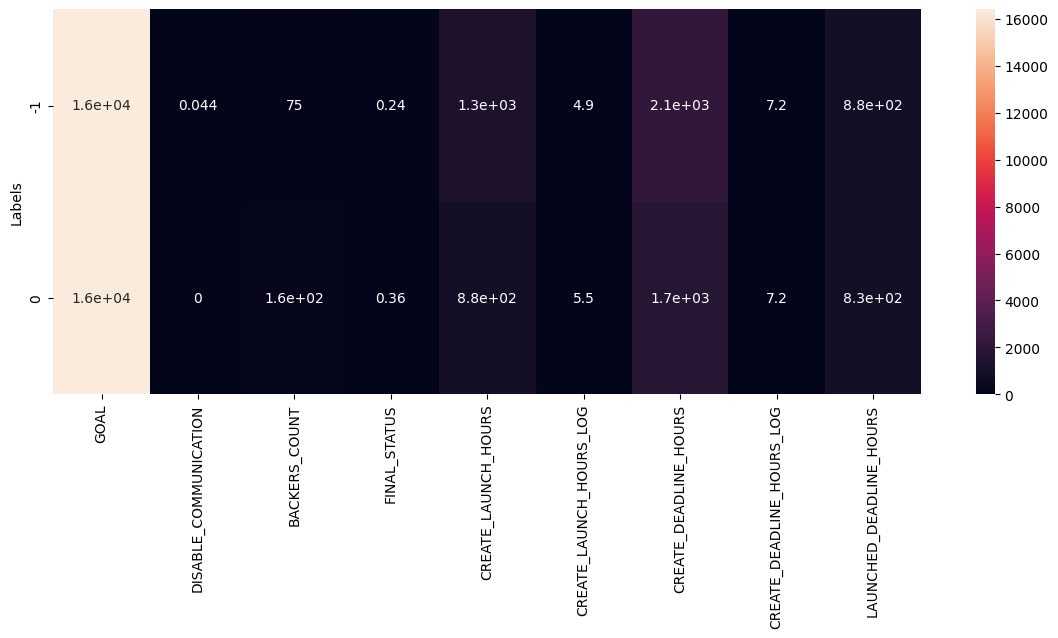

In [89]:
plt.figure(figsize=(14, 5))
sns.heatmap(
    df_dev_raw_subsample.groupby('Labels').mean(numeric_only=True),
    annot=True
);